In [1]:
#Attribute information [Source]:
#1. seismic: the result of shift seismic hazard assessment in the mine working obtained by the seismic method (a — lack of hazard, b — low hazard, c — high hazard, d — danger state);
#2. seismoacoustic: the result of shift seismic hazard assessment in the mine working obtained by the seismoacoustic method;
#3. shift: information about the type of a shift (W — coal-getting, N -preparation shift);
#4. genergy: seismic energy recorded within the previous shift by the most active geophone (GMax) out of
#geophones monitoring the longwall;
#5. gpuls: a number of pulses recorded within the previous shift by GMax;
#6. gdenergy: a deviation of energy recorded within the previous shift by GMax from average energy recorded during eight previous shifts;
#7. gdpuls: a deviation of a number of pulses recorded within the previous shift by GMax from the average number of pulses recorded during eight previous shifts;
#8. ghazard: the result of shift seismic hazard assessment in the mine working obtained by the seismoacoustic method based on registration coming to from GMax only;
#9. nbumps: the number of seismic bumps recorded within the previous shift;
#10. nbumps2: the number of seismic bumps (in energy range [1⁰²,1⁰³)) registered within the previous shift;
#11. nbumps3: the number of seismic bumps (in energy range [1⁰³,1⁰⁴)) registered within the previous shift;
#12. nbumps4: the number of seismic bumps (in energy range [1⁰⁴,1⁰⁵)) registered within the previous shift;
#13. nbumps5: the number of seismic bumps (in energy range [1⁰⁵,1⁰⁶)) registered within the last shift;
#14. nbumps6: the number of seismic bumps (in energy range [1⁰⁶,1⁰⁷)) registered within the previous shift;
#15. nbumps7: the number of seismic bumps (in energy range [1⁰⁷,1⁰⁸)) registered within the previous shift;
#16. nbumps89: the number of seismic bumps (in energy range [1⁰⁸,1⁰¹⁰)) registered within the previous shift;
#17. energy: the total energy of seismic bumps registered within the previous shift;
#18. maxenergy: the maximum energy of the seismic bumps registered within the previous shift;
#19. class: the decision attribute — ‘1’ means that high energy seismic bump occurred in the next shift (‘hazardous state’), ‘0’ means that no high energy seismic bumps occurred in the next shift (‘non-hazardous state’).#

In [120]:
!pip install tabulate

%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from tabulate import tabulate
from collections import defaultdict
from scipy.stats.stats import pearsonr

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram

In [3]:
df = pd.read_csv('seismic-bumps.csv')
df.dtypes

seismic           object
seismoacoustic    object
shift             object
genergy            int64
gpuls              int64
gdenergy           int64
gdpuls             int64
hazard            object
nbumps             int64
nbumps2            int64
nbumps3            int64
nbumps4            int64
nbumps5            int64
nbumps6            int64
nbumps7            int64
nbumps89           int64
energy             int64
maxenergy          int64
class              int64
dtype: object

In [4]:
df = df.convert_dtypes()
df.dtypes

seismic           string
seismoacoustic    string
shift             string
genergy            Int64
gpuls              Int64
gdenergy           Int64
gdpuls             Int64
hazard            string
nbumps             Int64
nbumps2            Int64
nbumps3            Int64
nbumps4            Int64
nbumps5            Int64
nbumps6            Int64
nbumps7            Int64
nbumps89           Int64
energy             Int64
maxenergy          Int64
class              Int64
dtype: object

In [5]:
df.head()

seismic seismoacoustic shift  genergy  gpuls  gdenergy  gdpuls hazard  \
0       a              a     N    15180     48       -72     -72      a   
1       a              a     N    14720     33       -70     -79      a   
2       a              a     N     8050     30       -81     -78      a   
3       a              a     N    28820    171       -23      40      a   
4       a              a     N    12640     57       -63     -52      a   

   nbumps  nbumps2  nbumps3  nbumps4  nbumps5  nbumps6  nbumps7  nbumps89  \
0       0        0        0        0        0        0        0         0   
1       1        0        1        0        0        0        0         0   
2       0        0        0        0        0        0        0         0   
3       1        0        1        0        0        0        0         0   
4       0        0        0        0        0        0        0         0   

   energy  maxenergy  class  
0       0          0      0  
1    2000       2000      0  
2       0          0      0  
3    3000       3000      0  
4       0          0      0

In [6]:
df.tail()

seismic seismoacoustic shift  genergy  gpuls  gdenergy  gdpuls hazard  \
2579       b              a     W    81410    785       432     151      b   
2580       b              a     W    42110    555       213     118      a   
2581       b              a     W    26960    540       101     112      a   
2582       a              a     W    16130    322         2       2      a   
2583       a              a     W    12750    235       -10     -10      a   

      nbumps  nbumps2  nbumps3  nbumps4  nbumps5  nbumps6  nbumps7  nbumps89  \
2579       0        0        0        0        0        0        0         0   
2580       0        0        0        0        0        0        0         0   
2581       0        0        0        0        0        0        0         0   
2582       0        0        0        0        0        0        0         0   
2583       0        0        0        0        0        0        0         0   

      energy  maxenergy  class  
2579       0          0      0  
2580       0          0      0  
2581       0          0      0  
2582       0          0      0  
2583       0          0      0

In [7]:
df.shape

(2584, 19)

In [8]:
df.columns

Index(['seismic', 'seismoacoustic', 'shift', 'genergy', 'gpuls', 'gdenergy',
       'gdpuls', 'hazard', 'nbumps', 'nbumps2', 'nbumps3', 'nbumps4',
       'nbumps5', 'nbumps6', 'nbumps7', 'nbumps89', 'energy', 'maxenergy',
       'class'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2584 entries, 0 to 2583
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   seismic         2584 non-null   string
 1   seismoacoustic  2584 non-null   string
 2   shift           2584 non-null   string
 3   genergy         2584 non-null   Int64 
 4   gpuls           2584 non-null   Int64 
 5   gdenergy        2584 non-null   Int64 
 6   gdpuls          2584 non-null   Int64 
 7   hazard          2584 non-null   string
 8   nbumps          2584 non-null   Int64 
 9   nbumps2         2584 non-null   Int64 
 10  nbumps3         2584 non-null   Int64 
 11  nbumps4         2584 non-null   Int64 
 12  nbumps5         2584 non-null   Int64 
 13  nbumps6         2584 non-null   Int64 
 14  nbumps7         2584 non-null   Int64 
 15  nbumps89        2584 non-null   Int64 
 16  energy          2584 non-null   Int64 
 17  maxenergy       2584 non-null   Int64 
 18  class   

In [10]:
df['seismic'] = df['seismic'].astype("category")
df['seismoacoustic'] = df['seismoacoustic'].astype("category")
df['shift'] = df['shift'].astype("category")
df['genergy'] = df['genergy'].astype(float)
df['gpuls'] = df['gpuls'].astype(float)
df['gdenergy'] = df['gdenergy'].astype(float)
df['gdpuls'] = df['gdpuls'].astype(float)
df['hazard'] = df['hazard'].astype("category")
df['nbumps'] = df['nbumps'].astype(float)
df['nbumps2'] = df['nbumps2'].astype(float)
df['nbumps3'] = df['nbumps3'].astype(float)
df['nbumps4'] = df['nbumps4'].astype(float)
df['nbumps5'] = df['nbumps5'].astype(float)
df['nbumps6'] = df['nbumps6'].astype(float)
df['nbumps7'] = df['nbumps7'].astype(float)
df['nbumps89'] = df['nbumps89'].astype(float)
df['energy'] = df['energy'].astype(float)
df['maxenergy'] = df['maxenergy'].astype(float)
df['class'] = df['class'].astype(float)

df.dtypes

seismic           category
seismoacoustic    category
shift             category
genergy            float64
gpuls              float64
gdenergy           float64
gdpuls             float64
hazard            category
nbumps             float64
nbumps2            float64
nbumps3            float64
nbumps4            float64
nbumps5            float64
nbumps6            float64
nbumps7            float64
nbumps89           float64
energy             float64
maxenergy          float64
class              float64
dtype: object

In [11]:
categorical_columns = ['seismic','seismoacoustic','shift','hazard']

#Print frequency of categories
for col in categorical_columns:
    print ('\nFrequency of Categories for variable %s'%col)
    print (df[col].value_counts())


Frequency of Categories for variable seismic
a    1682
b     902
Name: seismic, dtype: int64

Frequency of Categories for variable seismoacoustic
a    1580
b     956
c      48
Name: seismoacoustic, dtype: int64

Frequency of Categories for variable shift
W    1663
N     921
Name: shift, dtype: int64

Frequency of Categories for variable hazard
a    2342
b     212
c      30
Name: hazard, dtype: int64


# CATEGORICAL VARIABLES DISTRIBUTION ANALYSIS

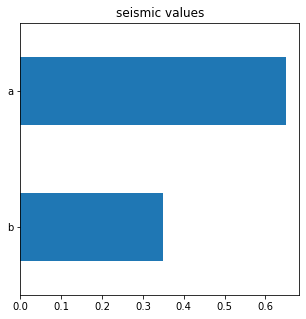

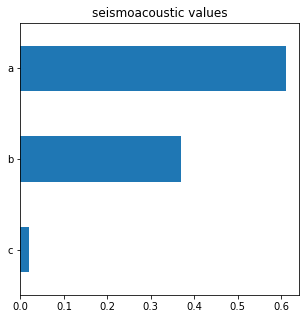

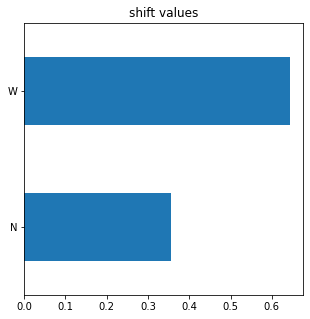

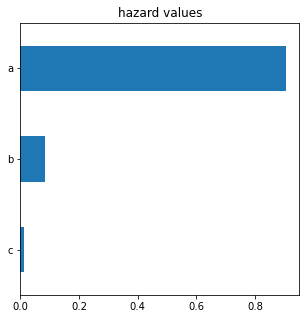

In [12]:
#overview of distributions
selected_columns = df[['seismic','seismoacoustic','shift','hazard']]
df_categorical = selected_columns.copy()
for e in df_categorical:
    df[e].value_counts(normalize=True, ascending=True).plot(kind='barh', title=f'{e} values',  figsize=(5,5))
    plt.show()

##  NUMERICAL VARIABLES DISTRIBUTION ANALYSIS

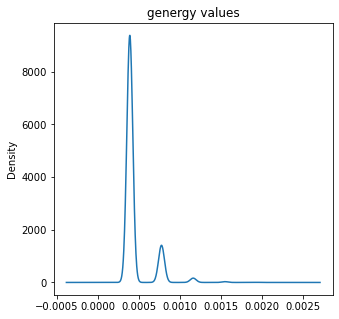

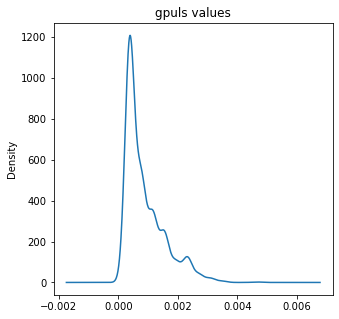

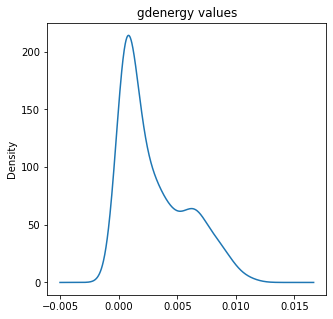

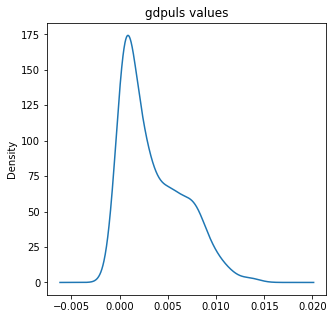

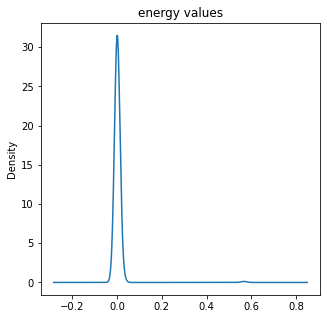

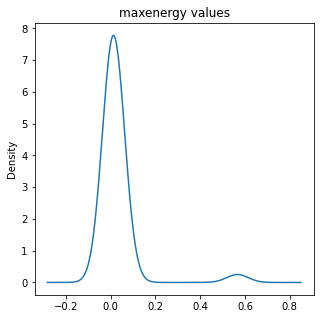

In [13]:
#overview of distributions
selected_columns = df[['genergy','gpuls','gdenergy','gdpuls', 'energy', 'maxenergy']]
df_numerical = selected_columns.copy()
for e in df_numerical:
    df[e].value_counts(normalize=True).plot(kind='density', title=f'{e} values',  figsize=(5,5))
    plt.show()

#### as we can see, the variables above assume a right skewed distribution. This means that the majority of values are located in left part, around zero.

## DISCRETE VARIABLES DISTRIBUTION ANALYSIS

array([[<AxesSubplot:title={'center':'nbumps'}>,
        <AxesSubplot:title={'center':'nbumps2'}>,
        <AxesSubplot:title={'center':'nbumps3'}>],
       [<AxesSubplot:title={'center':'nbumps4'}>,
        <AxesSubplot:title={'center':'nbumps5'}>,
        <AxesSubplot:title={'center':'nbumps6'}>],
       [<AxesSubplot:title={'center':'nbumps7'}>,
        <AxesSubplot:title={'center':'nbumps89'}>, <AxesSubplot:>]],
      dtype=object)

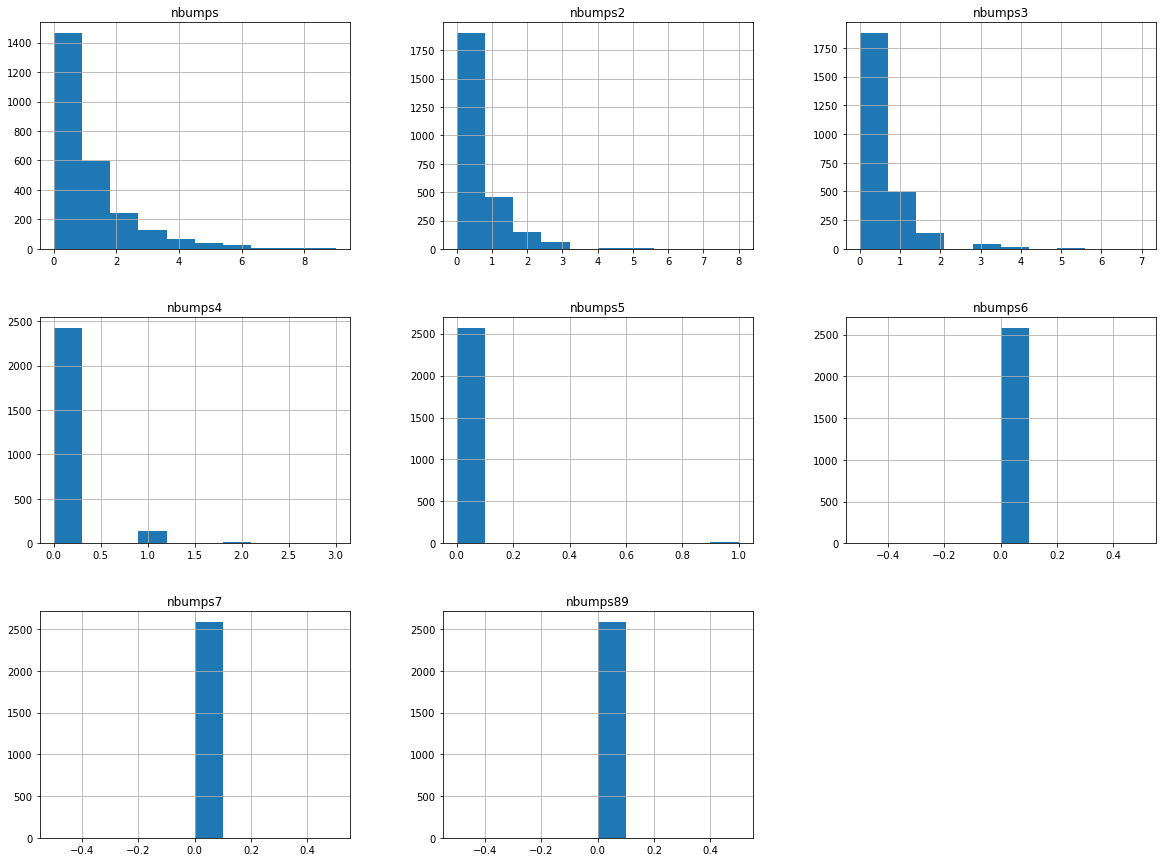

In [14]:
#overview of distributions
selected_columns = df[['nbumps','nbumps2','nbumps3','nbumps4', 'nbumps5', 'nbumps6', 'nbumps7', 'nbumps89']]
df_discrete = selected_columns.copy()
df_discrete.hist(figsize=(20,15))

## DECISION VARIABLE

<AxesSubplot:xlabel='class', ylabel='count'>

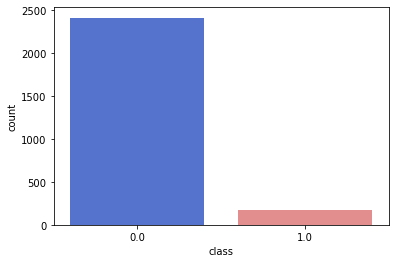

In [15]:
#df['class'].value_counts(normalize=True, ascending=True).plot(kind='barh', title='class values', colors=['#BB0000', '#0000BB'])

sns.countplot(x=df['class'], palette={0:'royalblue',1:'lightcoral'} )

In [16]:
df['class'].value_counts()  #in numero

0.0    2414
1.0     170
Name: class, dtype: int64

In [17]:
df.describe().T

count          mean            std    min      25%      50%  \
genergy    2584.0  90242.523220  229200.508894  100.0  11660.0  25485.0   
gpuls      2584.0    538.579334     562.652536    2.0    190.0    379.0   
gdenergy   2584.0     12.375774      80.319051  -96.0    -37.0     -6.0   
gdpuls     2584.0      4.508901      63.166556  -96.0    -36.0     -6.0   
nbumps     2584.0      0.859520       1.364616    0.0      0.0      0.0   
nbumps2    2584.0      0.393576       0.783772    0.0      0.0      0.0   
nbumps3    2584.0      0.392802       0.769710    0.0      0.0      0.0   
nbumps4    2584.0      0.067724       0.279059    0.0      0.0      0.0   
nbumps5    2584.0      0.004644       0.068001    0.0      0.0      0.0   
nbumps6    2584.0      0.000000       0.000000    0.0      0.0      0.0   
nbumps7    2584.0      0.000000       0.000000    0.0      0.0      0.0   
nbumps89   2584.0      0.000000       0.000000    0.0      0.0      0.0   
energy     2584.0   4975.270898   20450.833222    0.0      0.0      0.0   
maxenergy  2584.0   4278.850619   19357.454882    0.0      0.0      0.0   
class      2584.0      0.065789       0.247962    0.0      0.0      0.0   

                75%        max  
genergy    52832.50  2595650.0  
gpuls        669.00     4518.0  
gdenergy      38.00     1245.0  
gdpuls        30.25      838.0  
nbumps         1.00        9.0  
nbumps2        1.00        8.0  
nbumps3        1.00        7.0  
nbumps4        0.00        3.0  
nbumps5        0.00        1.0  
nbumps6        0.00        0.0  
nbumps7        0.00        0.0  
nbumps89       0.00        0.0  
energy      2600.00   402000.0  
maxenergy   2000.00   400000.0  
class          0.00        1.0

In [18]:
df.groupby('class').mean().T

class               0.0            1.0
genergy    82448.918807  200911.705882
gpuls        508.567109     964.752941
gdenergy      12.312759      13.270588
gdpuls         4.143745       9.694118
nbumps         0.769677       2.135294
nbumps2        0.351698       0.988235
nbumps3        0.350870       0.988235
nbumps4        0.062138       0.147059
nbumps5        0.004557       0.005882
nbumps6        0.000000       0.000000
nbumps7        0.000000       0.000000
nbumps89       0.000000       0.000000
energy      4658.222867    9477.352941
maxenergy   4072.162386    7213.823529

In [19]:
df.isnull().any()  # nessun true quindi nessun valore mancante

seismic           False
seismoacoustic    False
shift             False
genergy           False
gpuls             False
gdenergy          False
gdpuls            False
hazard            False
nbumps            False
nbumps2           False
nbumps3           False
nbumps4           False
nbumps5           False
nbumps6           False
nbumps7           False
nbumps89          False
energy            False
maxenergy         False
class             False
dtype: bool

### HIDDEN MISSING VALUES

In [20]:
# Eliminiamo tutte le righe dove nbumps è zero e genergy è superiore al secondo quartile perché li riteniamo missing values
df_nbumps = df[df['nbumps'] == 0]
df_genergy = df_nbumps[df_nbumps['genergy'] >= 25485.0]
df_genergy

seismic seismoacoustic shift   genergy  gpuls  gdenergy  gdpuls hazard  \
5          a              a     W   63760.0  195.0     -73.0   -65.0      a   
8          a              a     N  100190.0  303.0      54.0    52.0      a   
11         a              a     N   53250.0  140.0     -19.0   -31.0      a   
16         a              b     N   31290.0  117.0     -52.0   -41.0      a   
23         a              a     N   45630.0  155.0      49.0    52.0      a   
...      ...            ...   ...       ...    ...       ...     ...    ...   
2574       b              a     W   27740.0  443.0      81.0    41.0      a   
2578       b              a     W   28910.0  307.0     115.0    20.0      a   
2579       b              a     W   81410.0  785.0     432.0   151.0      b   
2580       b              a     W   42110.0  555.0     213.0   118.0      a   
2581       b              a     W   26960.0  540.0     101.0   112.0      a   

      nbumps  nbumps2  nbumps3  nbumps4  nbumps5  nbumps6  nbumps7  nbumps89  \
5        0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
8        0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
11       0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
16       0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
23       0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
...      ...      ...      ...      ...      ...      ...      ...       ...   
2574     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
2578     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
2579     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
2580     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
2581     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   

      energy  maxenergy  class  
5        0.0        0.0    0.0  
8        0.0        0.0    0.0  
11       0.0        0.0    0.0  
16       0.0        0.0    0.0  
23       0.0        0.0    0.0  
...      ...        ...    ...  
2574     0.0        0.0    0.0  
2578     0.0        0.0    0.0  
2579     0.0        0.0    0.0  
2580     0.0        0.0    0.0  
2581     0.0        0.0    0.0  

[486 rows x 19 columns]

In [21]:
df = df.drop(df_genergy.index)
df.shape

(2098, 19)

In [22]:
# Eliminiamo tutte le righe dove nbumps è zero e gpuls è superiore al secondo quartile perché li riteniamo missing values
df_nbumps = df[df['nbumps'] == 0]
df_gpuls = df_nbumps[df_nbumps['gpuls'] >= 379.0]
df_gpuls

seismic seismoacoustic shift  genergy  gpuls  gdenergy  gdpuls hazard  \
1105       a              a     W  18470.0  525.0     -46.0   -41.0      a   
1106       a              a     W  17220.0  529.0     -50.0   -41.0      a   
1107       a              a     W  25010.0  524.0     -27.0   -41.0      a   
1109       a              a     W  15170.0  414.0     -56.0   -54.0      a   
1135       a              b     W  23040.0  392.0     -10.0   -22.0      a   
...      ...            ...   ...      ...    ...       ...     ...    ...   
2498       a              a     W  19170.0  430.0      -1.0    29.0      a   
2509       a              a     W  10730.0  542.0      16.0    30.0      a   
2510       a              a     W  24320.0  427.0      56.0    51.0      a   
2511       a              a     W  23960.0  539.0      54.0    91.0      a   
2514       a              a     W  18370.0  486.0      18.0    72.0      a   

      nbumps  nbumps2  nbumps3  nbumps4  nbumps5  nbumps6  nbumps7  nbumps89  \
1105     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
1106     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
1107     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
1109     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
1135     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
...      ...      ...      ...      ...      ...      ...      ...       ...   
2498     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
2509     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
2510     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
2511     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   
2514     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0   

      energy  maxenergy  class  
1105     0.0        0.0    0.0  
1106     0.0        0.0    0.0  
1107     0.0        0.0    0.0  
1109     0.0        0.0    0.0  
1135     0.0        0.0    0.0  
...      ...        ...    ...  
2498     0.0        0.0    0.0  
2509     0.0        0.0    0.0  
2510     0.0        0.0    0.0  
2511     0.0        0.0    0.0  
2514     0.0        0.0    0.0  

[222 rows x 19 columns]

In [23]:
df = df.drop(df_gpuls.index)
df.shape

(1876, 19)

In [24]:
confusion_matrix = pd.crosstab(df['seismic'], df['class'])
confusion_matrix

class     0.0  1.0
seismic           
a        1205   68
b         533   70

## LOG TRANSFORMED HISTPLOTS

<AxesSubplot:xlabel='genergy', ylabel='Density'>

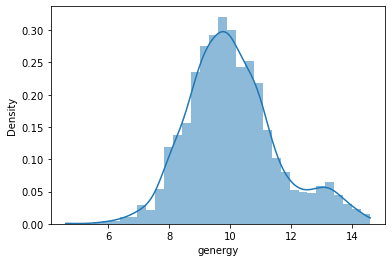

In [25]:
sns.histplot(np.log(df['genergy']), kde=True, stat="density", linewidth=0)

<AxesSubplot:xlabel='gpuls', ylabel='Density'>

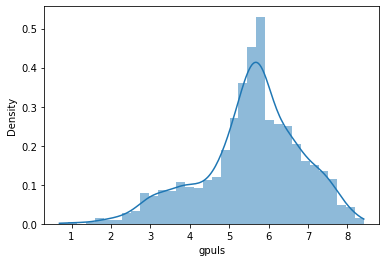

In [26]:
sns.histplot(np.log(df['gpuls']), kde=True, stat="density", linewidth=0)

In [27]:
df_corr = df.corr() # assegno a una variabile per usarla alla ricerca dei nan nella correlazione

In [28]:
nan_df = df_corr[df_corr.isna().any(axis=1)]  #1 per colonne e 0 per righe
nan_df.head()   # tutte le colonne con un valore nan nella correlazione (le prime sono date dalle righe delle colonne tolte)


genergy     gpuls  gdenergy    gdpuls    nbumps   nbumps2  \
genergy   1.000000  0.767756  0.089594  0.137605  0.272347  0.170964   
gpuls     0.767756  1.000000  0.311661  0.416716  0.413746  0.282138   
gdenergy  0.089594  0.311661  1.000000  0.816394  0.157604  0.144796   
gdpuls    0.137605  0.416716  0.816394  1.000000  0.225681  0.181088   
nbumps    0.272347  0.413746  0.157604  0.225681  1.000000  0.781642   

           nbumps3   nbumps4   nbumps5  nbumps6  nbumps7  nbumps89    energy  \
genergy   0.230066  0.174791 -0.012008      NaN      NaN       NaN  0.092903   
gpuls     0.304525  0.305103  0.059926      NaN      NaN       NaN  0.228168   
gdenergy  0.075353  0.089034  0.167613      NaN      NaN       NaN  0.177456   
gdpuls    0.133264  0.138910  0.198453      NaN      NaN       NaN  0.240697   
nbumps    0.778931  0.369987  0.057935      NaN      NaN       NaN  0.318082   

          maxenergy     class  
genergy    0.073660  0.162187  
gpuls      0.200279  0.245989  
gdenergy   0.176598  0.006391  
gdpuls     0.235984  0.042468  
nbumps     0.242082  0.276071

In [29]:
print(df['nbumps6'].value_counts())
print(df['nbumps7'].value_counts())
print(df['nbumps89'].value_counts())

0.0    1876
Name: nbumps6, dtype: int64
0.0    1876
Name: nbumps7, dtype: int64
0.0    1876
Name: nbumps89, dtype: int64


### as seen before with the histograms, nbumps6, nbumps7 and nbumps89 contain only zero, so they can be dropped

In [30]:
df = df.drop('nbumps6', 1) 
df = df.drop('nbumps7', 1) 
df = df.drop('nbumps89', 1) 
df.head() 
df.tail(100) # per vedere se il 2 ha qualche numero


seismic seismoacoustic shift  genergy  gpuls  gdenergy  gdpuls hazard  \
2459       b              a     W   7240.0  164.0     -51.0   -57.0      a   
2460       b              a     W   6580.0  161.0     -75.0   -63.0      a   
2461       b              a     W  28590.0  387.0       8.0   -10.0      a   
2462       b              a     W  16820.0  244.0     -32.0   -39.0      a   
2463       b              a     W  15650.0  664.0      45.0    42.0      a   
...      ...            ...   ...      ...    ...       ...     ...    ...   
2575       b              a     W  15460.0  249.0      15.0    -2.0      a   
2576       b              a     W  22060.0  275.0      64.0     8.0      a   
2577       b              a     W  16330.0  270.0       7.0   -14.0      a   
2582       a              a     W  16130.0  322.0       2.0     2.0      a   
2583       a              a     W  12750.0  235.0     -10.0   -10.0      a   

      nbumps  nbumps2  nbumps3  nbumps4  nbumps5  energy  maxenergy  class  
2459     0.0      0.0      0.0      0.0      0.0     0.0        0.0    0.0  
2460     0.0      0.0      0.0      0.0      0.0     0.0        0.0    0.0  
2461     2.0      2.0      0.0      0.0      0.0  1300.0      900.0    0.0  
2462     0.0      0.0      0.0      0.0      0.0     0.0        0.0    0.0  
2463     1.0      1.0      0.0      0.0      0.0   800.0      800.0    0.0  
...      ...      ...      ...      ...      ...     ...        ...    ...  
2575     0.0      0.0      0.0      0.0      0.0     0.0        0.0    0.0  
2576     0.0      0.0      0.0      0.0      0.0     0.0        0.0    0.0  
2577     0.0      0.0      0.0      0.0      0.0     0.0        0.0    0.0  
2582     0.0      0.0      0.0      0.0      0.0     0.0        0.0    0.0  
2583     0.0      0.0      0.0      0.0      0.0     0.0        0.0    0.0  

[100 rows x 16 columns]

## NBUMPS CROSSTAB

### Since bumps are the number of seismic bumps recorded within the previous shift, it makes sense to check the entity of these bumps, so in which class they fall (0 = non hazardous; 1 = hazardous). We can check it with a crosstab

In [31]:
bumps_col = ['nbumps','nbumps2','nbumps3','nbumps4','nbumps5'] #to do that I select only the significant nbumps

In [32]:
for col in bumps_col:
    bumps_crosstab = pd.crosstab(df[col], df['class'], colnames=['class'], margins = True) #margins is to add the totals
    print(bumps_crosstab)
    print('-----')

class    0.0  1.0   All
nbumps                 
0.0      748    8   756
1.0      567   31   598
2.0      208   37   245
3.0       96   31   127
4.0       59   10    69
5.0       30    8    38
6.0       19    9    28
7.0        3    2     5
8.0        6    1     7
9.0        2    1     3
All     1738  138  1876
-----
class     0.0  1.0   All
nbumps2                 
0.0      1156   37  1193
1.0       399   56   455
2.0       122   29   151
3.0        47   11    58
4.0         8    4    12
5.0         5    1     6
8.0         1    0     1
All      1738  138  1876
-----
class     0.0  1.0   All
nbumps3                 
0.0      1130   41  1171
1.0       442   55   497
2.0       115   25   140
3.0        35    7    42
4.0        12    8    20
5.0         3    2     5
7.0         1    0     1
All      1738  138  1876
-----
class     0.0  1.0   All
nbumps4                 
0.0      1602  116  1718
1.0       123   20   143
2.0        12    1    13
3.0         1    1     2
All      1738  138  

### Crosstab with the percentages, to better see the percentage of 0s in comparison to the 1s

In [33]:
for col in bumps_col:
    bumps_crosstab = pd.crosstab(df[col], df['class'], colnames=['class'], margins = True).apply(lambda r: r/r.sum(), axis = 1) #margins is to add the totals
    print(bumps_crosstab)
    print('-----')

class        0.0       1.0  All
nbumps                         
0.0     0.494709  0.005291  0.5
1.0     0.474080  0.025920  0.5
2.0     0.424490  0.075510  0.5
3.0     0.377953  0.122047  0.5
4.0     0.427536  0.072464  0.5
5.0     0.394737  0.105263  0.5
6.0     0.339286  0.160714  0.5
7.0     0.300000  0.200000  0.5
8.0     0.428571  0.071429  0.5
9.0     0.333333  0.166667  0.5
All     0.463220  0.036780  0.5
-----
class         0.0       1.0  All
nbumps2                         
0.0      0.484493  0.015507  0.5
1.0      0.438462  0.061538  0.5
2.0      0.403974  0.096026  0.5
3.0      0.405172  0.094828  0.5
4.0      0.333333  0.166667  0.5
5.0      0.416667  0.083333  0.5
8.0      0.500000  0.000000  0.5
All      0.463220  0.036780  0.5
-----
class         0.0       1.0  All
nbumps3                         
0.0      0.482494  0.017506  0.5
1.0      0.444668  0.055332  0.5
2.0      0.410714  0.089286  0.5
3.0      0.416667  0.083333  0.5
4.0      0.300000  0.200000  0.5
5.0      0.

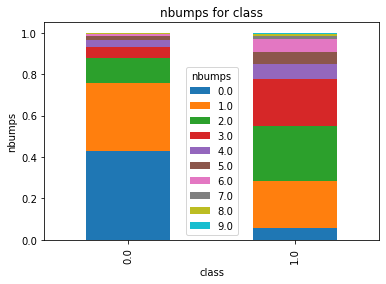

In [34]:
pclass_xt = pd.crosstab(df['class'], df['nbumps'])
pclass_xt_pct = pclass_xt.div(pclass_xt.sum(1).astype(float), axis=0)  #li trasformo in modo che il valore vada da 0 a 1
pclass_xt_pct.plot(kind='bar', stacked=True, 
                   title='nbumps for class')
plt.xlabel('class')
plt.ylabel('nbumps')
plt.show()

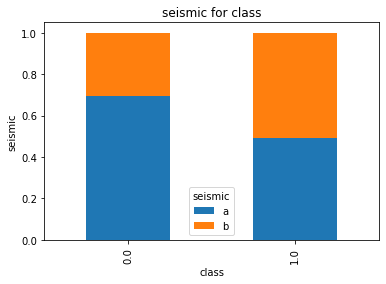

In [35]:
classandseismic = pd.crosstab(df['class'], df['seismic'])
classandseismic = classandseismic.div(classandseismic.sum(1).astype(float), axis=0)
classandseismic.plot(kind='bar', stacked=True, 
                   title='seismic for class')
plt.xlabel('class')
plt.ylabel('seismic')
plt.show()

In [36]:
classnbumps2=pd.crosstab(df['class'], df['nbumps2'])   #trasformo le crosstab in valori da 1 a 0
classnbumps3=pd.crosstab(df['class'], df['nbumps3'])
classnbumps4 = pd.crosstab(df['class'], df['nbumps4'])
classnbumps5= pd.crosstab(df['class'], df['nbumps5'])
classgenergy= pd.crosstab(df['class'], [df['gdenergy'].quantile(0), df['gdenergy'].quantile(0.25), df['gdenergy'].quantile(0.50), df['gdenergy'].quantile(0.75), df['gdenergy'].quantile(1)])
classgpuls= pd.crosstab(df['class'], [df['gpuls'].quantile(0), df['gpuls'].quantile(0.25), df['gpuls'].quantile(0.50), df['gpuls'].quantile(0.75), df['gpuls'].quantile(1)])
classnbumps2=classnbumps2.div(classnbumps2.sum(1).astype(float), axis=0)
classnbumps3=classnbumps3.div(classnbumps3.sum(1).astype(float), axis=0)
classnbumps4=classnbumps4.div(classnbumps4.sum(1).astype(float), axis=0)
classnbumps5=classnbumps5.div(classnbumps5.sum(1).astype(float), axis=0)
classgenergy=classgenergy.div(classnbumps5.sum(1).astype(float), axis=0)
classgpuls=classgpuls.div(classgpuls.sum(1).astype(float), axis=0)


In [37]:
df['gdenergy'].quantile(1)

1245.0

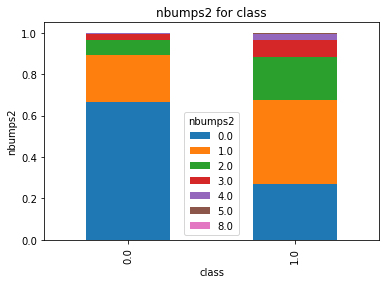

In [38]:
classnbumps2.plot(kind='bar', stacked=True, 
                   title='nbumps2 for class')
plt.xlabel('class')
plt.ylabel('nbumps2')
plt.show()

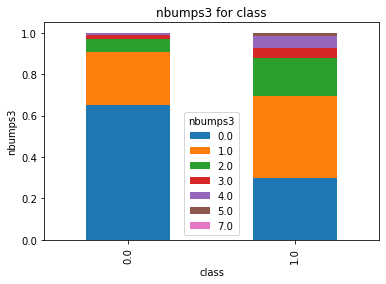

In [39]:
classnbumps3.plot(kind='bar', stacked=True, 
                   title='nbumps3 for class')
plt.xlabel('class')
plt.ylabel('nbumps3')
plt.show()

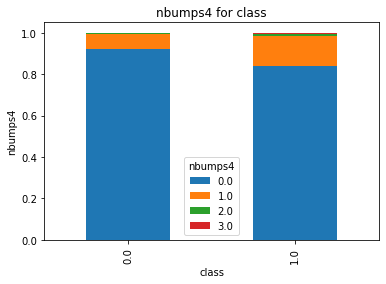

In [40]:
classnbumps4.plot(kind='bar', stacked=True, 
                   title='nbumps4 for class')
plt.xlabel('class')
plt.ylabel('nbumps4')
plt.show()

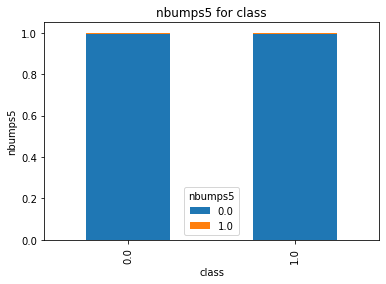

In [41]:
classnbumps5.plot(kind='bar', stacked=True, 
                   title='nbumps5 for class')
plt.xlabel('class')
plt.ylabel('nbumps5')
plt.show()

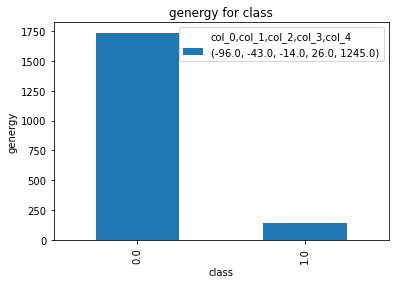

In [42]:
classgenergy.plot(kind='bar', stacked=True, 
                   title='genergy for class')
plt.xlabel('class')
plt.ylabel('genergy')
plt.show()

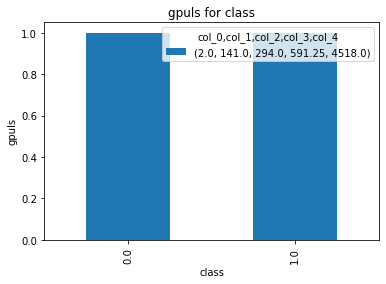

In [43]:
classgpuls.plot(kind='bar', stacked=True, 
                   title='gpuls for class')
plt.xlabel('class')
plt.ylabel('gpuls')
plt.show()

#### the crosstab highlight that the majority of bumps - also the ones which registered an energy intensity in the upperbound of the range - have been classified as 'non-harzardous state', since belonging to the class 0. 

## CORRELATION AND HEATMAP

In [44]:
df.corr() #vedo correlazione senza valori inutili

genergy     gpuls  gdenergy    gdpuls    nbumps   nbumps2  \
genergy    1.000000  0.767756  0.089594  0.137605  0.272347  0.170964   
gpuls      0.767756  1.000000  0.311661  0.416716  0.413746  0.282138   
gdenergy   0.089594  0.311661  1.000000  0.816394  0.157604  0.144796   
gdpuls     0.137605  0.416716  0.816394  1.000000  0.225681  0.181088   
nbumps     0.272347  0.413746  0.157604  0.225681  1.000000  0.781642   
nbumps2    0.170964  0.282138  0.144796  0.181088  0.781642  1.000000   
nbumps3    0.230066  0.304525  0.075353  0.133264  0.778931  0.281182   
nbumps4    0.174791  0.305103  0.089034  0.138910  0.369987  0.122569   
nbumps5   -0.012008  0.059926  0.167613  0.198453  0.057935 -0.019149   
energy     0.092903  0.228168  0.177456  0.240697  0.318082  0.083493   
maxenergy  0.073660  0.200279  0.176598  0.235984  0.242082  0.045761   
class      0.162187  0.245989  0.006391  0.042468  0.276071  0.217514   

            nbumps3   nbumps4   nbumps5    energy  maxenergy     class  
genergy    0.230066  0.174791 -0.012008  0.092903   0.073660  0.162187  
gpuls      0.304525  0.305103  0.059926  0.228168   0.200279  0.245989  
gdenergy   0.075353  0.089034  0.167613  0.177456   0.176598  0.006391  
gdpuls     0.133264  0.138910  0.198453  0.240697   0.235984  0.042468  
nbumps     0.778931  0.369987  0.057935  0.318082   0.242082  0.276071  
nbumps2    0.281182  0.122569 -0.019149  0.083493   0.045761  0.217514  
nbumps3    1.000000  0.136900  0.035142  0.210045   0.142322  0.222221  
nbumps4    0.136900  1.000000 -0.023116  0.478197   0.404458  0.076476  
nbumps5    0.035142 -0.023116  1.000000  0.776736   0.810929  0.003004  
energy     0.210045  0.478197  0.776736  1.000000   0.989426  0.057266  
maxenergy  0.142322  0.404458  0.810929  0.989426   1.000000  0.037476  
class      0.222221  0.076476  0.003004  0.057266   0.037476  1.000000

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0, 0.5, 'genergy'),
  Text(0, 1.5, 'gpuls'),
  Text(0, 2.5, 'gdenergy'),
  Text(0, 3.5, 'gdpuls'),
  Text(0, 4.5, 'nbumps'),
  Text(0, 5.5, 'nbumps2'),
  Text(0, 6.5, 'nbumps3'),
  Text(0, 7.5, 'nbumps4'),
  Text(0, 8.5, 'nbumps5'),
  Text(0, 9.5, 'energy'),
  Text(0, 10.5, 'maxenergy'),
  Text(0, 11.5, 'class')])

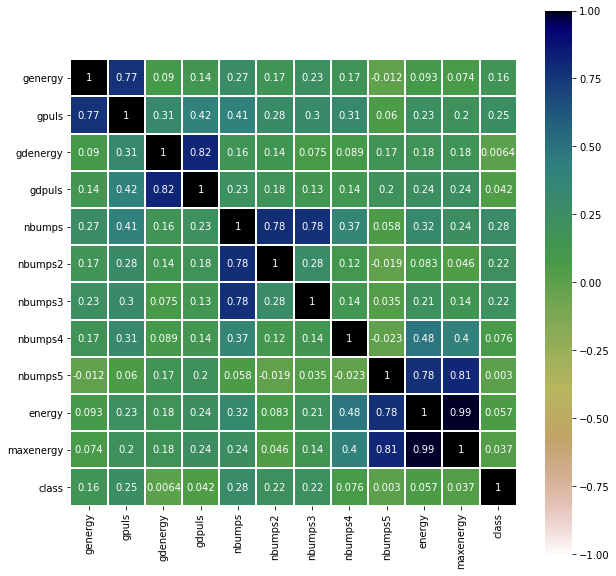

In [45]:
dfcorrelazione = df.corr()
plt.figure(figsize=[10, 10])
sns.heatmap(data=dfcorrelazione, vmin=-1, vmax=1, cmap='gist_earth_r', annot=True, square=True, linewidths=1)
plt.xticks(rotation=90)
plt.yticks(rotation=0)

## SCATTER PLOTS

<AxesSubplot:xlabel='energy', ylabel='gpuls'>

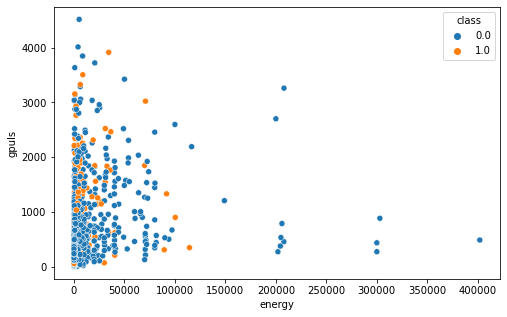

In [46]:
plt.figure(figsize=[8, 5])
sns.scatterplot(x='energy', y='gpuls', hue='class', data=df)

In [47]:
df['log_genergy'] = np.where(df['gdenergy'] > 0, np.log(df['genergy']), 0)
df['log_gdenergy'] = np.where(df['gdenergy'] > 0, np.log(df['gdenergy']), 0)
df['log_gpuls'] = np.log(df['gpuls'])
df['log_gdpuls'] = np.log(df['gdpuls'])

C:\Users\aless\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\aless\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='log_genergy', ylabel='log_gdenergy'>

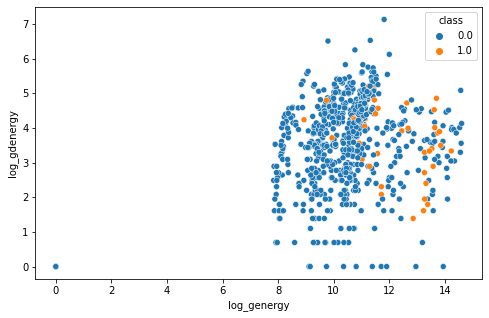

In [48]:
plt.figure(figsize=[8, 5])
sns.scatterplot(x='log_genergy', y='log_gdenergy', hue='class', data=df)

### To better analyse the correlation we apply a log transformation to the columns genergy and gpuls

<AxesSubplot:xlabel='log_genergy', ylabel='log_gpuls'>

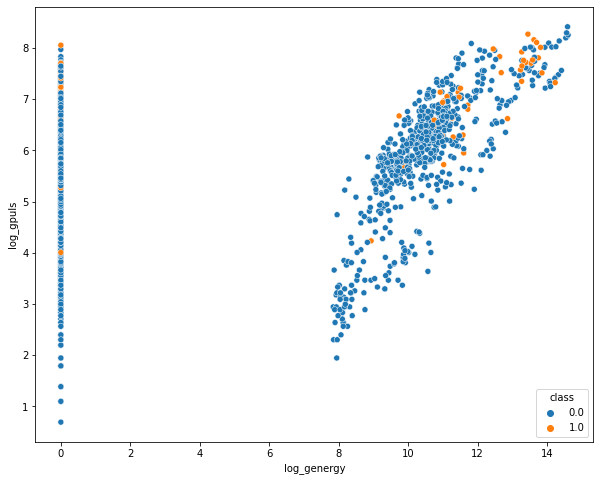

In [49]:
plt.figure(figsize=[10, 8])
sns.scatterplot(x='log_genergy', y='log_gpuls', hue='class', data=df)

#### After applying the log transf we can better see a positive correlation between gpuls and genergy. That could indicate that the number of puls increases when the energy does, so the number of pulse can be used as and indicator of the energy intensity. (The pulses have been registered by the most active geophone (Gmax), which is a sensor designed to detect ground movements).


<AxesSubplot:xlabel='gdenergy', ylabel='gdpuls'>

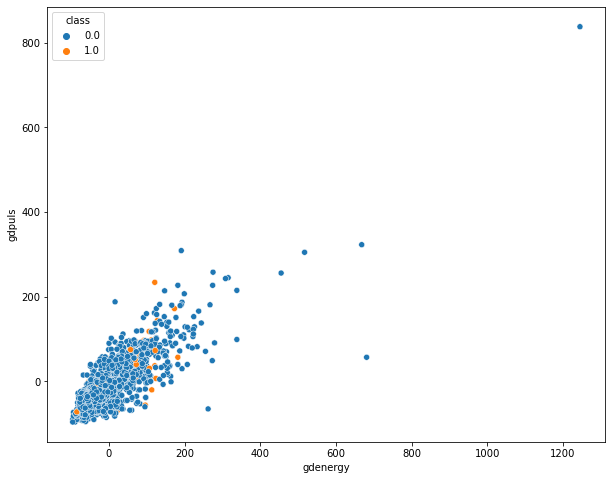

In [50]:
plt.figure(figsize=[10, 8])
sns.scatterplot(x='gdenergy', y='gdpuls', hue='class', data=df)

In [51]:
# sembrerebbe esserci correlazione, con una trasformazione sarebbe più semplice vederla (?). ho cercato altre trasformazioni e ho trovato Square Root Method, ma non sono riuscita ad applicarlo. 

## Inconsistency check

In [52]:
df_discrete.head()

nbumps  nbumps2  nbumps3  nbumps4  nbumps5  nbumps6  nbumps7  nbumps89
0     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0
1     1.0      0.0      1.0      0.0      0.0      0.0      0.0       0.0
2     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0
3     1.0      0.0      1.0      0.0      0.0      0.0      0.0       0.0
4     0.0      0.0      0.0      0.0      0.0      0.0      0.0       0.0

In [53]:
df.head()

seismic seismoacoustic shift  genergy  gpuls  gdenergy  gdpuls hazard  \
0       a              a     N  15180.0   48.0     -72.0   -72.0      a   
1       a              a     N  14720.0   33.0     -70.0   -79.0      a   
2       a              a     N   8050.0   30.0     -81.0   -78.0      a   
3       a              a     N  28820.0  171.0     -23.0    40.0      a   
4       a              a     N  12640.0   57.0     -63.0   -52.0      a   

   nbumps  nbumps2  nbumps3  nbumps4  nbumps5  energy  maxenergy  class  \
0     0.0      0.0      0.0      0.0      0.0     0.0        0.0    0.0   
1     1.0      0.0      1.0      0.0      0.0  2000.0     2000.0    0.0   
2     0.0      0.0      0.0      0.0      0.0     0.0        0.0    0.0   
3     1.0      0.0      1.0      0.0      0.0  3000.0     3000.0    0.0   
4     0.0      0.0      0.0      0.0      0.0     0.0        0.0    0.0   

   log_genergy  log_gdenergy  log_gpuls  log_gdpuls  
0          0.0           0.0   3.871201         NaN  
1          0.0           0.0   3.496508         NaN  
2          0.0           0.0   3.401197         NaN  
3          0.0           0.0   5.141664    3.688879  
4          0.0           0.0   4.043051         NaN

In [54]:
selected_columns = df[['nbumps2','nbumps3','nbumps4', 'nbumps5']]
df_discrete = selected_columns.copy()
df[df['nbumps'] != df_discrete.sum(axis=1)] # ci sono due righe inconsistenti

seismic seismoacoustic shift  genergy  gpuls  gdenergy  gdpuls hazard  \
436       b              a     N   5500.0  152.0     -51.0    -1.0      a   
437       a              a     N   4630.0   89.0     -56.0   -42.0      a   

     nbumps  nbumps2  nbumps3  nbumps4  nbumps5  energy  maxenergy  class  \
436     2.0      1.0      0.0      0.0      0.0   250.0      200.0    0.0   
437     1.0      0.0      0.0      0.0      0.0    50.0       50.0    1.0   

     log_genergy  log_gdenergy  log_gpuls  log_gdpuls  
436          0.0           0.0   5.023881         NaN  
437          0.0           0.0   4.488636         NaN

In [55]:
# eliminiamo le due righe inconsistenti
df = df.drop(436)
df = df.drop(437)

In [56]:
df[df['maxenergy'] > df['energy']] # non ci sono inconsistenze tra energy e maxenergy

Empty DataFrame
Columns: [seismic, seismoacoustic, shift, genergy, gpuls, gdenergy, gdpuls, hazard, nbumps, nbumps2, nbumps3, nbumps4, nbumps5, energy, maxenergy, class, log_genergy, log_gdenergy, log_gpuls, log_gdpuls]
Index: []

In [57]:
df_nbumps = df[df['nbumps'] > 0]
df_nbumps[df_nbumps['energy'] <= 0]
# non ci sono inconsistenze

Empty DataFrame
Columns: [seismic, seismoacoustic, shift, genergy, gpuls, gdenergy, gdpuls, hazard, nbumps, nbumps2, nbumps3, nbumps4, nbumps5, energy, maxenergy, class, log_genergy, log_gdenergy, log_gpuls, log_gdpuls]
Index: []

In [58]:
df_nbumps = df[df['nbumps2'] > 0]
df_nbumps[df_nbumps['maxenergy'] < 10^2]
# non ci sono inconsistenze

Empty DataFrame
Columns: [seismic, seismoacoustic, shift, genergy, gpuls, gdenergy, gdpuls, hazard, nbumps, nbumps2, nbumps3, nbumps4, nbumps5, energy, maxenergy, class, log_genergy, log_gdenergy, log_gpuls, log_gdpuls]
Index: []

In [59]:
df_nbumps = df[df['nbumps3'] > 0]
df_nbumps[df_nbumps['maxenergy'] < 10^3]
# non ci sono inconsistenze

Empty DataFrame
Columns: [seismic, seismoacoustic, shift, genergy, gpuls, gdenergy, gdpuls, hazard, nbumps, nbumps2, nbumps3, nbumps4, nbumps5, energy, maxenergy, class, log_genergy, log_gdenergy, log_gpuls, log_gdpuls]
Index: []

In [60]:
df_nbumps = df[df['nbumps4'] > 0]
df_nbumps[df_nbumps['maxenergy'] < 10^4]
# non ci sono inconsistenze

Empty DataFrame
Columns: [seismic, seismoacoustic, shift, genergy, gpuls, gdenergy, gdpuls, hazard, nbumps, nbumps2, nbumps3, nbumps4, nbumps5, energy, maxenergy, class, log_genergy, log_gdenergy, log_gpuls, log_gdpuls]
Index: []

In [61]:
df_nbumps = df[df['nbumps5'] > 0]
df_nbumps[df_nbumps['maxenergy'] < 10^5]
# non ci sono inconsistenze

Empty DataFrame
Columns: [seismic, seismoacoustic, shift, genergy, gpuls, gdenergy, gdpuls, hazard, nbumps, nbumps2, nbumps3, nbumps4, nbumps5, energy, maxenergy, class, log_genergy, log_gdenergy, log_gpuls, log_gdpuls]
Index: []

## OUTLIER DETECTION

<AxesSubplot:>

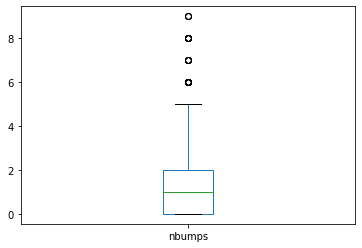

In [62]:
df['nbumps'].plot(kind = 'box')

In [63]:
df[df['nbumps'] >= 8] # quelli maggiori di 8 non sono outlier

seismic seismoacoustic shift   genergy   gpuls  gdenergy  gdpuls hazard  \
392       b              b     W  184710.0  1482.0      61.0    78.0      a   
422       b              b     W   60390.0   622.0      96.0    96.0      a   
428       b              b     W   47500.0   668.0      12.0    46.0      a   
445       b              b     W   61140.0   306.0      22.0   -69.0      a   
448       b              b     W   73820.0   322.0     -16.0   -14.0      a   
449       b              b     W  102380.0   508.0      19.0    37.0      a   
533       b              b     W   45470.0   573.0      64.0    65.0      a   
723       b              a     W  185910.0  2451.0       8.0    24.0      a   
724       b              a     W  197590.0  2804.0      20.0    44.0      a   
757       a              a     W   32550.0   167.0      17.0    -8.0      a   

     nbumps  nbumps2  nbumps3  nbumps4  nbumps5   energy  maxenergy  class  \
392     9.0      1.0      7.0      1.0      0.0  49800.0    30000.0    0.0   
422     9.0      4.0      4.0      1.0      0.0  40600.0    20000.0    1.0   
428     8.0      4.0      2.0      2.0      0.0  97100.0    50000.0    0.0   
445     8.0      5.0      2.0      1.0      0.0  89400.0    80000.0    1.0   
448     8.0      3.0      3.0      2.0      0.0  52700.0    30000.0    0.0   
449     8.0      4.0      4.0      0.0      0.0  13400.0     8000.0    0.0   
533     8.0      5.0      2.0      1.0      0.0  33600.0    20000.0    0.0   
723     8.0      4.0      4.0      0.0      0.0  11300.0     4000.0    0.0   
724     8.0      8.0      0.0      0.0      0.0   4700.0      800.0    0.0   
757     9.0      5.0      4.0      0.0      0.0  13200.0     6000.0    0.0   

     log_genergy  log_gdenergy  log_gpuls  log_gdpuls  
392    12.126542      4.110874   7.301148    4.356709  
422    11.008579      4.564348   6.432940    4.564348  
428    10.768485      2.484907   6.504288    3.828641  
445    11.020922      3.091042   5.723585         NaN  
448     0.000000      0.000000   5.774552         NaN  
449    11.536447      2.944439   6.230481    3.610918  
533    10.724808      4.158883   6.350886    4.174387  
723    12.133018      2.079442   7.804251    3.178054  
724    12.193949      2.995732   7.938802    3.784190  
757    10.390533      2.833213   5.117994         NaN

<AxesSubplot:>

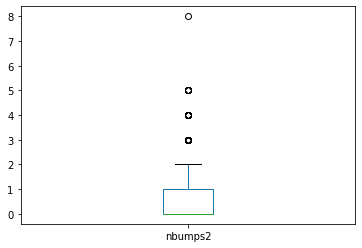

In [64]:
df['nbumps2'].plot(kind = 'box') #from this output we can say that the majority of seismic bumps occurred with an energy in the range of 0 to 1

In [65]:
df[df['nbumps2'] >= 8] # (?) forse è un outlier perché è uno solo

seismic seismoacoustic shift   genergy   gpuls  gdenergy  gdpuls hazard  \
724       b              a     W  197590.0  2804.0      20.0    44.0      a   

     nbumps  nbumps2  nbumps3  nbumps4  nbumps5  energy  maxenergy  class  \
724     8.0      8.0      0.0      0.0      0.0  4700.0      800.0    0.0   

     log_genergy  log_gdenergy  log_gpuls  log_gdpuls  
724    12.193949      2.995732   7.938802     3.78419

<AxesSubplot:>

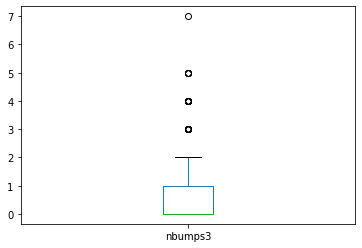

In [66]:
df['nbumps3'].plot(kind = 'box')

In [67]:
df[df['nbumps3'] >= 7] # (?) forse è un outlier perché è uno solo

seismic seismoacoustic shift   genergy   gpuls  gdenergy  gdpuls hazard  \
392       b              b     W  184710.0  1482.0      61.0    78.0      a   

     nbumps  nbumps2  nbumps3  nbumps4  nbumps5   energy  maxenergy  class  \
392     9.0      1.0      7.0      1.0      0.0  49800.0    30000.0    0.0   

     log_genergy  log_gdenergy  log_gpuls  log_gdpuls  
392    12.126542      4.110874   7.301148    4.356709

<AxesSubplot:>

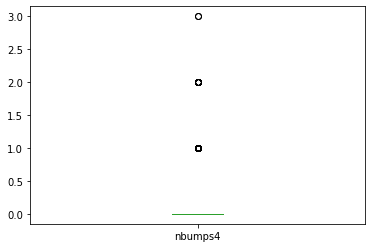

In [68]:
df['nbumps4'].plot(kind = 'box') 

In [69]:
df[df['nbumps4'] >= 3] # niente outliers

seismic seismoacoustic shift  genergy   gpuls  gdenergy  gdpuls hazard  \
421       b              b     W  29410.0   345.0      -6.0     7.0      a   
653       b              a     W  55890.0  1204.0      -3.0    34.0      a   

     nbumps  nbumps2  nbumps3  nbumps4  nbumps5    energy  maxenergy  class  \
421     7.0      1.0      3.0      3.0      0.0  114400.0    70000.0    1.0   
653     5.0      0.0      2.0      3.0      0.0  149000.0    80000.0    0.0   

     log_genergy  log_gdenergy  log_gpuls  log_gdpuls  
421          0.0           0.0   5.843544    1.945910  
653          0.0           0.0   7.093405    3.526361

<AxesSubplot:>

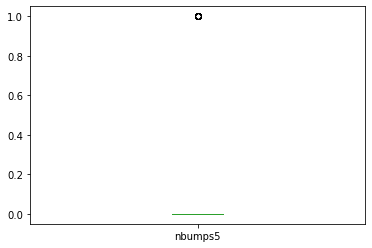

In [70]:
df['nbumps5'].plot(kind = 'box') 

In [71]:
df[df['nbumps5'] >= 1] # niente ouliers, nbumps5 è sempre o 0 o 1

seismic seismoacoustic shift   genergy   gpuls  gdenergy  gdpuls hazard  \
431        b              b     N   20340.0   271.0      16.0    93.0      a   
465        a              a     W   78430.0   455.0      12.0     8.0      a   
503        b              a     W   45330.0   485.0      -4.0    25.0      a   
555        a              b     W   60910.0   882.0      55.0    62.0      a   
597        b              a     W   47010.0   375.0      57.0    63.0      a   
696        b              b     W   83490.0   898.0     -49.0   -37.0      b   
1111       a              a     W  103380.0  2701.0     193.0   187.0      a   
1691       a              b     N  135210.0  3261.0    1245.0   838.0      b   
1740       b              a     N   18840.0   434.0     126.0   158.0      a   
2292       a              b     W   48050.0   531.0      92.0     6.0      a   
2402       a              b     N   30820.0   786.0     147.0   214.0      a   
2523       b              a     W   14050.0   271.0      -3.0     2.0      a   

      nbumps  nbumps2  nbumps3  nbumps4  nbumps5    energy  maxenergy  class  \
431      2.0      0.0      1.0      0.0      1.0  202000.0   200000.0    0.0   
465      5.0      1.0      3.0      0.0      1.0  207900.0   200000.0    0.0   
503      3.0      0.0      2.0      0.0      1.0  402000.0   400000.0    0.0   
555      2.0      0.0      1.0      0.0      1.0  303000.0   300000.0    0.0   
597      4.0      2.0      1.0      0.0      1.0  204400.0   200000.0    0.0   
696      2.0      1.0      0.0      0.0      1.0  100300.0   100000.0    1.0   
1111     1.0      0.0      0.0      0.0      1.0  200000.0   200000.0    0.0   
1691     2.0      0.0      1.0      0.0      1.0  208000.0   200000.0    0.0   
1740     1.0      0.0      0.0      0.0      1.0  300000.0   300000.0    0.0   
2292     2.0      0.0      1.0      0.0      1.0  205000.0   200000.0    0.0   
2402     2.0      0.0      1.0      0.0      1.0  206000.0   200000.0    0.0   
2523     1.0      0.0      0.0      0.0      1.0  300000.0   300000.0    0.0   

      log_genergy  log_gdenergy  log_gpuls  log_gdpuls  
431      9.920345      2.772589   5.602119    4.532599  
465     11.269962      2.484907   6.120297    2.079442  
503      0.000000      0.000000   6.184149    3.218876  
555     11.017153      4.007333   6.782192    4.127134  
597     10.758116      4.043051   5.926926    4.143135  
696      0.000000      0.000000   6.800170         NaN  
1111    11.546167      5.262690   7.901377    5.231109  
1691    11.814584      7.126891   8.089789    6.731018  
1740     9.843738      4.836282   6.073045    5.062595  
2292    10.779997      4.521789   6.274762    1.791759  
2402    10.335919      4.990433   6.666957    5.365976  
2523     0.000000      0.000000   5.602119    0.693147

<AxesSubplot:>

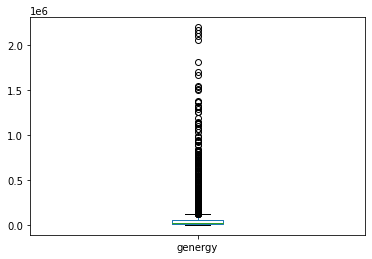

In [72]:
df['genergy'].plot(kind = 'box') 

In [73]:
df[df['genergy'] >= 2.5] # niente outliers

seismic seismoacoustic shift  genergy  gpuls  gdenergy  gdpuls hazard  \
0          a              a     N  15180.0   48.0     -72.0   -72.0      a   
1          a              a     N  14720.0   33.0     -70.0   -79.0      a   
2          a              a     N   8050.0   30.0     -81.0   -78.0      a   
3          a              a     N  28820.0  171.0     -23.0    40.0      a   
4          a              a     N  12640.0   57.0     -63.0   -52.0      a   
...      ...            ...   ...      ...    ...       ...     ...    ...   
2575       b              a     W  15460.0  249.0      15.0    -2.0      a   
2576       b              a     W  22060.0  275.0      64.0     8.0      a   
2577       b              a     W  16330.0  270.0       7.0   -14.0      a   
2582       a              a     W  16130.0  322.0       2.0     2.0      a   
2583       a              a     W  12750.0  235.0     -10.0   -10.0      a   

      nbumps  nbumps2  nbumps3  nbumps4  nbumps5  energy  maxenergy  class  \
0        0.0      0.0      0.0      0.0      0.0     0.0        0.0    0.0   
1        1.0      0.0      1.0      0.0      0.0  2000.0     2000.0    0.0   
2        0.0      0.0      0.0      0.0      0.0     0.0        0.0    0.0   
3        1.0      0.0      1.0      0.0      0.0  3000.0     3000.0    0.0   
4        0.0      0.0      0.0      0.0      0.0     0.0        0.0    0.0   
...      ...      ...      ...      ...      ...     ...        ...    ...   
2575     0.0      0.0      0.0      0.0      0.0     0.0        0.0    0.0   
2576     0.0      0.0      0.0      0.0      0.0     0.0        0.0    0.0   
2577     0.0      0.0      0.0      0.0      0.0     0.0        0.0    0.0   
2582     0.0      0.0      0.0      0.0      0.0     0.0        0.0    0.0   
2583     0.0      0.0      0.0      0.0      0.0     0.0        0.0    0.0   

      log_genergy  log_gdenergy  log_gpuls  log_gdpuls  
0        0.000000      0.000000   3.871201         NaN  
1        0.000000      0.000000   3.496508         NaN  
2        0.000000      0.000000   3.401197         NaN  
3        0.000000      0.000000   5.141664    3.688879  
4        0.000000      0.000000   4.043051         NaN  
...           ...           ...        ...         ...  
2575     9.646011      2.708050   5.517453         NaN  
2576    10.001521      4.158883   5.616771    2.079442  
2577     9.700759      1.945910   5.598422         NaN  
2582     9.688436      0.693147   5.774552    0.693147  
2583     0.000000      0.000000   5.459586         NaN  

[1874 rows x 20 columns]

<AxesSubplot:>

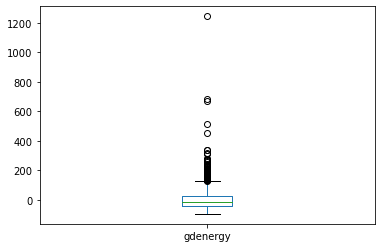

In [74]:
df['gdenergy'].plot(kind = 'box') 

In [75]:
df[df['gdenergy'] >= 1000] # è un outlier perché è uno solo

seismic seismoacoustic shift   genergy   gpuls  gdenergy  gdpuls hazard  \
1691       a              b     N  135210.0  3261.0    1245.0   838.0      b   

      nbumps  nbumps2  nbumps3  nbumps4  nbumps5    energy  maxenergy  class  \
1691     2.0      0.0      1.0      0.0      1.0  208000.0   200000.0    0.0   

      log_genergy  log_gdenergy  log_gpuls  log_gdpuls  
1691    11.814584      7.126891   8.089789    6.731018

<AxesSubplot:>

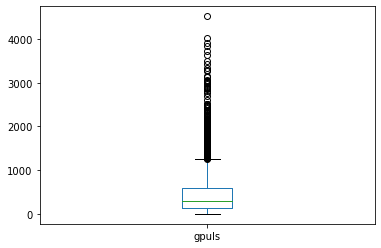

In [76]:
df['gpuls'].plot(kind = 'box') 

In [77]:
df[df['gpuls'] >= 4000] # niente outliers

seismic seismoacoustic shift    genergy   gpuls  gdenergy  gdpuls hazard  \
223       a              b     W  2160800.0  4518.0      35.0    57.0      a   
230       a              a     W  2102300.0  4014.0      27.0    26.0      a   

     nbumps  nbumps2  nbumps3  nbumps4  nbumps5  energy  maxenergy  class  \
223     4.0      2.0      2.0      0.0      0.0  5100.0     2000.0    0.0   
230     2.0      0.0      2.0      0.0      0.0  4000.0     3000.0    0.0   

     log_genergy  log_gdenergy  log_gpuls  log_gdpuls  
223    14.585989      3.555348   8.415825    4.043051  
230    14.558543      3.295837   8.297544    3.258097

<AxesSubplot:>

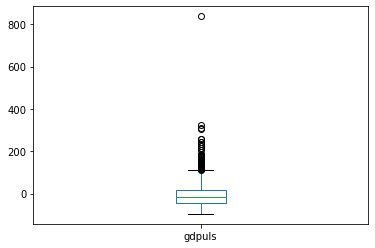

In [78]:
df['gdpuls'].plot(kind = 'box') 

In [79]:
df[df['gdpuls'] >= 800] # è un outlier perché è uno solo

seismic seismoacoustic shift   genergy   gpuls  gdenergy  gdpuls hazard  \
1691       a              b     N  135210.0  3261.0    1245.0   838.0      b   

      nbumps  nbumps2  nbumps3  nbumps4  nbumps5    energy  maxenergy  class  \
1691     2.0      0.0      1.0      0.0      1.0  208000.0   200000.0    0.0   

      log_genergy  log_gdenergy  log_gpuls  log_gdpuls  
1691    11.814584      7.126891   8.089789    6.731018

In [80]:
selected_columns = df[['genergy','gpuls','gdenergy','gdpuls', 'energy', 'maxenergy']]
df_numerical = selected_columns.copy()
for e in df_numerical:
    print(e, stats.iqr(df_numerical[e]))

genergy 45237.5
gpuls 450.75
gdenergy 69.0
gdpuls 62.0
energy 4000.0
maxenergy 3750.0


In [81]:
selected_columns = df[['nbumps','nbumps2','nbumps3','nbumps4', 'nbumps5']]
df_discrete = selected_columns.copy()
for e in df_discrete:
    print(e, stats.iqr(df_discrete[e]))

nbumps 2.0
nbumps2 1.0
nbumps3 1.0
nbumps4 0.0
nbumps5 0.0


In [82]:
#function that detect outliers based on IQR 
def outlier_detector(df_clean, var):
    ''' function that calculates Q1,Q3,IQR and return the number of outliers of a given variable'''
    Q1=df_clean[var].quantile(0.25)
    Q3=df_clean[var].quantile(0.75)
    IQR=Q3-Q1
    
    print(var)
    print(f'Q1: {Q1}\nQ3: {Q3}\nIQR: {IQR}')
    
    lower_whisker = Q1-1.5*IQR
    upper_whisker = Q3+1.5*IQR
    
    print(f'lower range: {lower_whisker}\nupper range: {upper_whisker}')
    df_lower = df_clean[df_clean[var] < lower_whisker]
    df_upper = df_clean[df_clean[var] > upper_whisker]
    outliers = sum(df_clean[var] < lower_whisker) + sum(df_clean[var] > upper_whisker)
    print(f'{var} has {outliers} potential outliers')
    return pd.concat([df_lower, df_upper])

In [83]:
df[df['nbumps'] > 0].shape

(1118, 20)

In [84]:
for e in df_numerical:
    print(df.shape)
    tmp = outlier_detector(df, e)
    print(tmp)
    print()
    df = df.drop(tmp.index)
    print(df.shape)
    

(1874, 20)
genergy
Q1: 8782.5
Q3: 54020.0
IQR: 45237.5
lower range: -59073.75
upper range: 121876.25
genergy has 249 potential outliers
     seismic seismoacoustic shift   genergy   gpuls  gdenergy  gdpuls hazard  \
6          a              a     W  207930.0   614.0      -6.0    18.0      a   
9          a              a     W  247620.0   675.0       4.0    25.0      a   
12         a              a     W  166180.0   448.0     -30.0   -19.0      a   
15         a              b     W  225040.0   575.0      -3.0     5.0      a   
24         a              a     W  424650.0  1069.0       1.0     7.0      a   
...      ...            ...   ...       ...     ...       ...     ...    ...   
881        a              a     W  129190.0   278.0      47.0    67.0      a   
935        a              b     N  147400.0   189.0      55.0    33.0      a   
1691       a              b     N  135210.0  3261.0    1245.0   838.0      b   
2180       b              b     W  162810.0  1768.0     455.0   

     seismic seismoacoustic shift  genergy  gpuls  gdenergy  gdpuls hazard  \
109        a              b     N  56120.0  222.0     100.0    89.0      a   
404        b              b     W  68970.0  624.0      71.0    94.0      a   
419        b              b     W  44020.0  528.0      61.0    92.0      a   
422        b              b     W  60390.0  622.0      96.0    96.0      a   
431        b              b     N  20340.0  271.0      16.0    93.0      a   
442        a              b     N  19320.0  320.0     106.0   118.0      b   
478        a              a     N  11390.0   89.0      47.0    94.0      a   
620        b              a     W  40250.0  451.0      91.0    91.0      a   
632        a              a     W  71080.0  767.0      88.0    94.0      a   
655        b              b     N   8660.0  205.0      16.0   188.0      b   
755        a              a     W  45990.0  349.0      59.0    94.0      a   
758        a              b     W  53860.0  346.0      96.0    9

maxenergy has 193 potential outliers
     seismic seismoacoustic shift  genergy  gpuls  gdenergy  gdpuls hazard  \
3          a              a     N  28820.0  171.0     -23.0    40.0      a   
7          a              a     N  48990.0  194.0     -27.0    -3.0      a   
10         a              a     N  41950.0  135.0     -39.0   -36.0      a   
13         a              a     N  64540.0  215.0       0.0     9.0      a   
21         a              a     N  11710.0   70.0     -72.0   -47.0      a   
...      ...            ...   ...      ...    ...       ...     ...    ...   
2487       a              a     W  10080.0  349.0      11.0    40.0      a   
2507       a              a     W  23580.0  462.0      34.0    46.0      a   
2515       a              a     W  18780.0  498.0      21.0    76.0      a   
2517       a              a     W  12080.0  310.0     -22.0    10.0      a   
2567       b              a     W  15740.0  222.0       4.0   -27.0      a   

      nbumps  nbumps2  nbu

In [85]:
df[df['nbumps'] > 0].shape

(353, 20)

In [86]:
for e in df_discrete:
    print(df.shape)
    tmp = outlier_detector(df, e)
    print(tmp)
    print()
    #df = df.drop(tmp.index) non li togliamo

(1088, 20)
nbumps
Q1: 0.0
Q3: 1.0
IQR: 1.0
lower range: -1.5
upper range: 2.5
nbumps has 39 potential outliers
     seismic seismoacoustic shift   genergy  gpuls  gdenergy  gdpuls hazard  \
435        b              a     W   38170.0  784.0     -27.0    12.0      a   
451        a              a     W   56810.0  285.0     -35.0   -27.0      a   
461        a              a     W   92380.0  514.0      25.0    29.0      a   
464        a              a     W   80210.0  525.0      18.0    32.0      a   
468        a              b     W  104410.0  631.0      54.0    50.0      a   
476        a              a     W   69070.0  505.0      -4.0    35.0      a   
481        a              a     W   39050.0  305.0     -40.0   -19.0      a   
485        a              a     W   53170.0  461.0       9.0    23.0      a   
495        b              a     W   24490.0  237.0     -51.0   -42.0      a   
511        a              b     W   31510.0  323.0     -22.0   -27.0      a   
514        a        

2347    11.013864      4.521789   6.661855    4.369448  

(1088, 20)
nbumps2
Q1: 0.0
Q3: 1.0
IQR: 1.0
lower range: -1.5
upper range: 2.5
nbumps2 has 22 potential outliers
     seismic seismoacoustic shift  genergy  gpuls  gdenergy  gdpuls hazard  \
461        a              a     W  92380.0  514.0      25.0    29.0      a   
476        a              a     W  69070.0  505.0      -4.0    35.0      a   
481        a              a     W  39050.0  305.0     -40.0   -19.0      a   
495        b              a     W  24490.0  237.0     -51.0   -42.0      a   
511        a              b     W  31510.0  323.0     -22.0   -27.0      a   
514        a              a     W  29340.0  294.0     -25.0   -31.0      a   
523        a              b     W  20160.0  262.0     -40.0   -39.0      a   
527        a              a     W  23630.0  294.0     -20.0   -29.0      a   
545        a              a     W  54830.0  694.0      46.0    68.0      a   
548        a              a     W  46740.0  553.0

Empty DataFrame
Columns: [seismic, seismoacoustic, shift, genergy, gpuls, gdenergy, gdpuls, hazard, nbumps, nbumps2, nbumps3, nbumps4, nbumps5, energy, maxenergy, class, log_genergy, log_gdenergy, log_gpuls, log_gdpuls]
Index: []



In [87]:
df.shape

(1088, 20)

In [88]:
df[df['nbumps'] > 0].shape

(353, 20)

[]

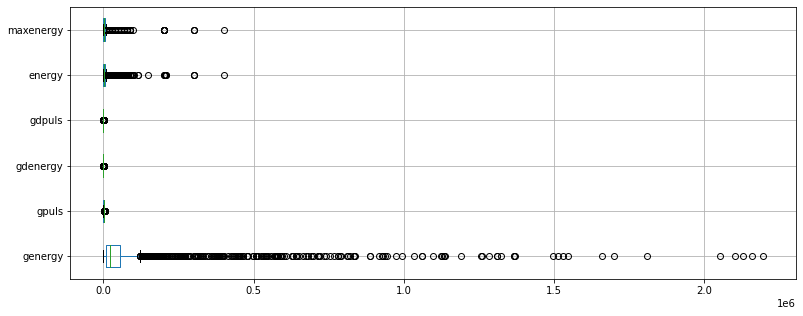

In [89]:
df_numerical.boxplot(return_type = 'dict', figsize=(13,5),vert=False)
plt.plot()

[]

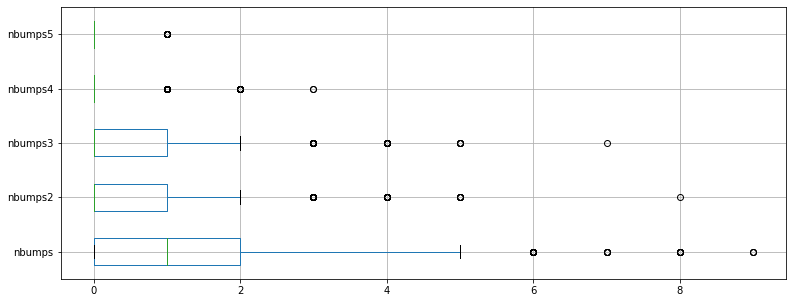

In [90]:
df_discrete.boxplot(return_type = 'dict', figsize=(13,5),vert=False)
plt.plot()

In [91]:
df.corr()

genergy     gpuls  gdenergy    gdpuls    nbumps   nbumps2  \
genergy       1.000000  0.593806  0.344958  0.347898  0.641568  0.559436   
gpuls         0.593806  1.000000  0.348791  0.547392  0.449503  0.417367   
gdenergy      0.344958  0.348791  1.000000  0.676353  0.211773  0.218269   
gdpuls        0.347898  0.547392  0.676353  1.000000  0.267453  0.258680   
nbumps        0.641568  0.449503  0.211773  0.267453  1.000000  0.888033   
nbumps2       0.559436  0.417367  0.218269  0.258680  0.888033  1.000000   
nbumps3       0.420165  0.251363  0.081793  0.132041  0.627730  0.199538   
nbumps4            NaN       NaN       NaN       NaN       NaN       NaN   
nbumps5            NaN       NaN       NaN       NaN       NaN       NaN   
energy        0.553319  0.360138  0.146513  0.198275  0.858770  0.564646   
maxenergy     0.527566  0.369265  0.126752  0.169988  0.733471  0.439225   
class         0.124580  0.113412  0.025492  0.062027  0.185201  0.174295   
log_genergy   0.322809  0.285055  0.807372  0.530996  0.219739  0.211149   
log_gdenergy  0.287613  0.253291  0.868030  0.539192  0.191791  0.191555   
log_gpuls     0.498016  0.857145  0.255685  0.541147  0.354336  0.329869   
log_gdpuls    0.183705  0.120959  0.437828  0.884523  0.185024  0.200969   

               nbumps3  nbumps4  nbumps5    energy  maxenergy     class  \
genergy       0.420165      NaN      NaN  0.553319   0.527566  0.124580   
gpuls         0.251363      NaN      NaN  0.360138   0.369265  0.113412   
gdenergy      0.081793      NaN      NaN  0.146513   0.126752  0.025492   
gdpuls        0.132041      NaN      NaN  0.198275   0.169988  0.062027   
nbumps        0.627730      NaN      NaN  0.858770   0.733471  0.185201   
nbumps2       0.199538      NaN      NaN  0.564646   0.439225  0.174295   
nbumps3       1.000000      NaN      NaN  0.874248   0.819554  0.099613   
nbumps4            NaN      NaN      NaN       NaN        NaN       NaN   
nbumps5            NaN      NaN      NaN       NaN        NaN       NaN   
energy        0.874248      NaN      NaN  1.000000   0.914332  0.128156   
maxenergy     0.819554      NaN      NaN  0.914332   1.000000  0.115622   
class         0.099613      NaN      NaN  0.128156   0.115622  1.000000   
log_genergy   0.110826      NaN      NaN  0.166586   0.143794 -0.004541   
log_gdenergy  0.084436      NaN      NaN  0.136568   0.114045 -0.001143   
log_gpuls     0.196681      NaN      NaN  0.286333   0.295807  0.103080   
log_gdpuls    0.062228      NaN      NaN  0.151395   0.162283 -0.091570   

              log_genergy  log_gdenergy  log_gpuls  log_gdpuls  
genergy          0.322809      0.287613   0.498016    0.183705  
gpuls            0.285055      0.253291   0.857145    0.120959  
gdenergy         0.807372      0.868030   0.255685    0.437828  
gdpuls           0.530996      0.539192   0.541147    0.884523  
nbumps           0.219739      0.191791   0.354336    0.185024  
nbumps2          0.211149      0.191555   0.329869    0.200969  
nbumps3          0.110826      0.084436   0.196681    0.062228  
nbumps4               NaN           NaN        NaN         NaN  
nbumps5               NaN           NaN        NaN         NaN  
energy           0.166586      0.136568   0.286333    0.151395  
maxenergy        0.143794      0.114045   0.295807    0.162283  
class           -0.004541     -0.001143   0.103080   -0.091570  
log_genergy      1.000000      0.929585   0.167896    0.371544  
log_gdenergy     0.929585      1.000000   0.139148    0.425090  
log_gpuls        0.167896      0.139148   1.000000    0.024850  
log_gdpuls       0.371544      0.425090   0.024850    1.000000

In [92]:
df = df.drop('nbumps4', 1)
df = df.drop('nbumps5', 1) 

In [93]:
df.corr()

genergy     gpuls  gdenergy    gdpuls    nbumps   nbumps2  \
genergy       1.000000  0.593806  0.344958  0.347898  0.641568  0.559436   
gpuls         0.593806  1.000000  0.348791  0.547392  0.449503  0.417367   
gdenergy      0.344958  0.348791  1.000000  0.676353  0.211773  0.218269   
gdpuls        0.347898  0.547392  0.676353  1.000000  0.267453  0.258680   
nbumps        0.641568  0.449503  0.211773  0.267453  1.000000  0.888033   
nbumps2       0.559436  0.417367  0.218269  0.258680  0.888033  1.000000   
nbumps3       0.420165  0.251363  0.081793  0.132041  0.627730  0.199538   
energy        0.553319  0.360138  0.146513  0.198275  0.858770  0.564646   
maxenergy     0.527566  0.369265  0.126752  0.169988  0.733471  0.439225   
class         0.124580  0.113412  0.025492  0.062027  0.185201  0.174295   
log_genergy   0.322809  0.285055  0.807372  0.530996  0.219739  0.211149   
log_gdenergy  0.287613  0.253291  0.868030  0.539192  0.191791  0.191555   
log_gpuls     0.498016  0.857145  0.255685  0.541147  0.354336  0.329869   
log_gdpuls    0.183705  0.120959  0.437828  0.884523  0.185024  0.200969   

               nbumps3    energy  maxenergy     class  log_genergy  \
genergy       0.420165  0.553319   0.527566  0.124580     0.322809   
gpuls         0.251363  0.360138   0.369265  0.113412     0.285055   
gdenergy      0.081793  0.146513   0.126752  0.025492     0.807372   
gdpuls        0.132041  0.198275   0.169988  0.062027     0.530996   
nbumps        0.627730  0.858770   0.733471  0.185201     0.219739   
nbumps2       0.199538  0.564646   0.439225  0.174295     0.211149   
nbumps3       1.000000  0.874248   0.819554  0.099613     0.110826   
energy        0.874248  1.000000   0.914332  0.128156     0.166586   
maxenergy     0.819554  0.914332   1.000000  0.115622     0.143794   
class         0.099613  0.128156   0.115622  1.000000    -0.004541   
log_genergy   0.110826  0.166586   0.143794 -0.004541     1.000000   
log_gdenergy  0.084436  0.136568   0.114045 -0.001143     0.929585   
log_gpuls     0.196681  0.286333   0.295807  0.103080     0.167896   
log_gdpuls    0.062228  0.151395   0.162283 -0.091570     0.371544   

              log_gdenergy  log_gpuls  log_gdpuls  
genergy           0.287613   0.498016    0.183705  
gpuls             0.253291   0.857145    0.120959  
gdenergy          0.868030   0.255685    0.437828  
gdpuls            0.539192   0.541147    0.884523  
nbumps            0.191791   0.354336    0.185024  
nbumps2           0.191555   0.329869    0.200969  
nbumps3           0.084436   0.196681    0.062228  
energy            0.136568   0.286333    0.151395  
maxenergy         0.114045   0.295807    0.162283  
class            -0.001143   0.103080   -0.091570  
log_genergy       0.929585   0.167896    0.371544  
log_gdenergy      1.000000   0.139148    0.425090  
log_gpuls         0.139148   1.000000    0.024850  
log_gdpuls        0.425090   0.024850    1.000000

In [94]:
df_log = df
df = df.drop('log_genergy', 1) 
df = df.drop('log_gdenergy', 1)
df = df.drop('log_gpuls', 1)
df = df.drop('log_gdpuls', 1)

df_log = df_log.drop('genergy', 1) 
df_log = df_log.drop('gdenergy', 1)
df_log = df_log.drop('gpuls', 1)
df_log = df_log.drop('gdpuls', 1)

In [95]:
df_log.corr()

nbumps   nbumps2   nbumps3    energy  maxenergy     class  \
nbumps        1.000000  0.888033  0.627730  0.858770   0.733471  0.185201   
nbumps2       0.888033  1.000000  0.199538  0.564646   0.439225  0.174295   
nbumps3       0.627730  0.199538  1.000000  0.874248   0.819554  0.099613   
energy        0.858770  0.564646  0.874248  1.000000   0.914332  0.128156   
maxenergy     0.733471  0.439225  0.819554  0.914332   1.000000  0.115622   
class         0.185201  0.174295  0.099613  0.128156   0.115622  1.000000   
log_genergy   0.219739  0.211149  0.110826  0.166586   0.143794 -0.004541   
log_gdenergy  0.191791  0.191555  0.084436  0.136568   0.114045 -0.001143   
log_gpuls     0.354336  0.329869  0.196681  0.286333   0.295807  0.103080   
log_gdpuls    0.185024  0.200969  0.062228  0.151395   0.162283 -0.091570   

              log_genergy  log_gdenergy  log_gpuls  log_gdpuls  
nbumps           0.219739      0.191791   0.354336    0.185024  
nbumps2          0.211149      0.191555   0.329869    0.200969  
nbumps3          0.110826      0.084436   0.196681    0.062228  
energy           0.166586      0.136568   0.286333    0.151395  
maxenergy        0.143794      0.114045   0.295807    0.162283  
class           -0.004541     -0.001143   0.103080   -0.091570  
log_genergy      1.000000      0.929585   0.167896    0.371544  
log_gdenergy     0.929585      1.000000   0.139148    0.425090  
log_gpuls        0.167896      0.139148   1.000000    0.024850  
log_gdpuls       0.371544      0.425090   0.024850    1.000000

In [96]:
df.corr()

genergy     gpuls  gdenergy    gdpuls    nbumps   nbumps2  \
genergy    1.000000  0.593806  0.344958  0.347898  0.641568  0.559436   
gpuls      0.593806  1.000000  0.348791  0.547392  0.449503  0.417367   
gdenergy   0.344958  0.348791  1.000000  0.676353  0.211773  0.218269   
gdpuls     0.347898  0.547392  0.676353  1.000000  0.267453  0.258680   
nbumps     0.641568  0.449503  0.211773  0.267453  1.000000  0.888033   
nbumps2    0.559436  0.417367  0.218269  0.258680  0.888033  1.000000   
nbumps3    0.420165  0.251363  0.081793  0.132041  0.627730  0.199538   
energy     0.553319  0.360138  0.146513  0.198275  0.858770  0.564646   
maxenergy  0.527566  0.369265  0.126752  0.169988  0.733471  0.439225   
class      0.124580  0.113412  0.025492  0.062027  0.185201  0.174295   

            nbumps3    energy  maxenergy     class  
genergy    0.420165  0.553319   0.527566  0.124580  
gpuls      0.251363  0.360138   0.369265  0.113412  
gdenergy   0.081793  0.146513   0.126752  0.025492  
gdpuls     0.132041  0.198275   0.169988  0.062027  
nbumps     0.627730  0.858770   0.733471  0.185201  
nbumps2    0.199538  0.564646   0.439225  0.174295  
nbumps3    1.000000  0.874248   0.819554  0.099613  
energy     0.874248  1.000000   0.914332  0.128156  
maxenergy  0.819554  0.914332   1.000000  0.115622  
class      0.099613  0.128156   0.115622  1.000000

In [97]:
cols = ['genergy', 'gpuls', 'gdenergy', 'gdpuls', 'nbumps', 'nbumps2', 'nbumps3', 'energy', 'maxenergy']
#cols = ['nbumps', 'energy']
df_x = cols.copy()
X = df[cols].values

In [98]:
scaler = StandardScaler()
X_scal = scaler.fit_transform(X)

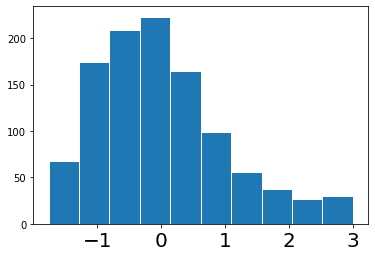

In [99]:
plt.hist(X_scal[:,2], edgecolor='white')

plt.xticks(fontsize=20)
plt.show()

In [100]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)
X_minmax

array([[0.124197  , 0.05330243, 0.11483254, ..., 0.        , 0.        ,
        0.        ],
       [0.1204085 , 0.03592121, 0.12440191, ..., 0.33333333, 0.32786885,
        1.        ],
       [0.06547521, 0.03244496, 0.07177033, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.13366826, 0.31054461, 0.49282297, ..., 0.        , 0.        ,
        0.        ],
       [0.13202108, 0.37079954, 0.46889952, ..., 0.        , 0.        ,
        0.        ],
       [0.10418382, 0.26998841, 0.41148325, ..., 0.        , 0.        ,
        0.        ]])

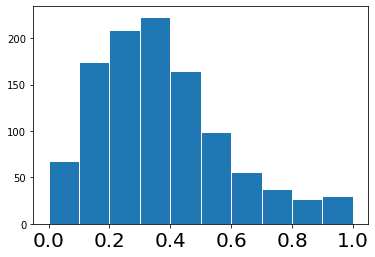

In [101]:
plt.hist(X_minmax[:,2], edgecolor='white')

plt.xticks(fontsize=20)
plt.show()

In [102]:
kmeans = KMeans( n_clusters=2, n_init=10, max_iter=100 )
kmeans.fit(X)

KMeans(max_iter=100, n_clusters=2)

In [103]:
len(cols)

9

In [104]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [105]:
centers = kmeans.cluster_centers_
kmeans.cluster_centers_

array([[ 1.14921244e+04,  1.95796891e+02, -2.34777202e+01,
        -2.71481865e+01,  2.95336788e-01,  2.21761658e-01,
         7.35751295e-02,  2.20000000e+02,  1.92435233e+02],
       [ 5.45265041e+04,  4.73747967e+02,  1.87967480e+01,
         9.20325203e+00,  1.90243902e+00,  1.29268293e+00,
         6.09756098e-01,  1.55447154e+03,  9.95934959e+02]])

In [106]:
kmeans.tol

0.0001

In [107]:
kmeans.n_iter_

14

In [108]:
kmeans.n_features_in_

9

genergy
genergy


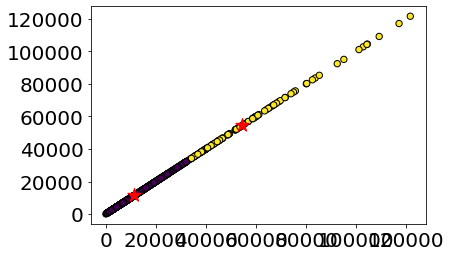

genergy
gpuls


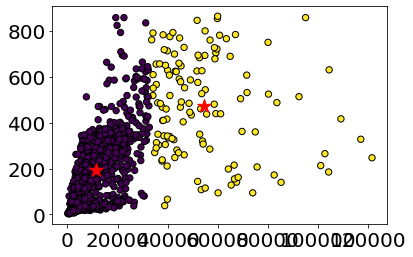

genergy
gdenergy


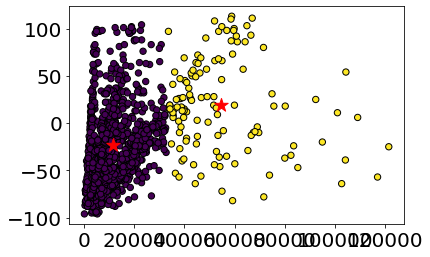

genergy
gdpuls


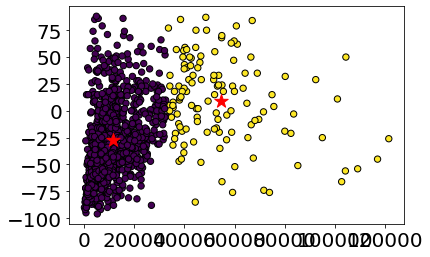

genergy
nbumps


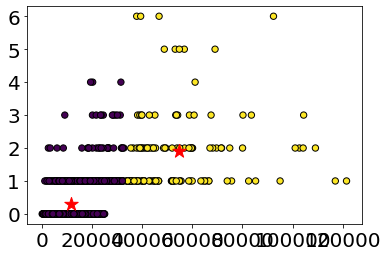

genergy
nbumps2


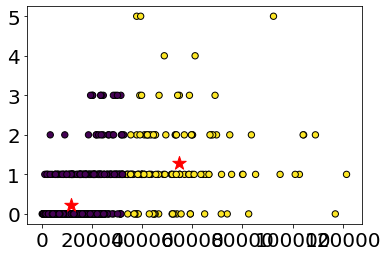

genergy
nbumps3


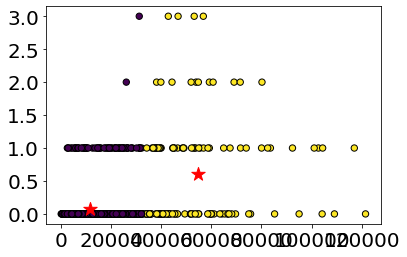

genergy
energy


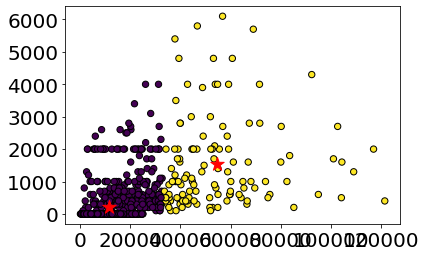

gpuls
genergy


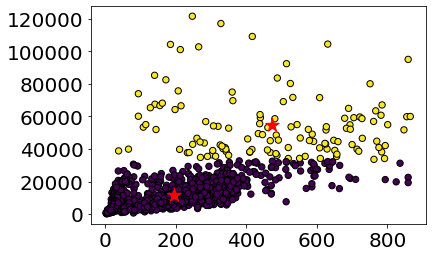

gpuls
gpuls


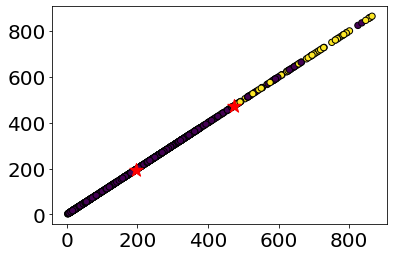

gpuls
gdenergy


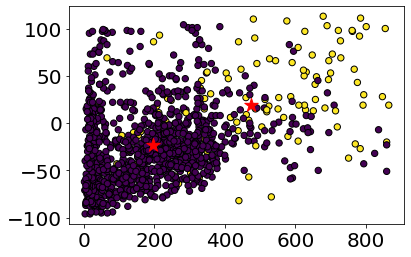

gpuls
gdpuls


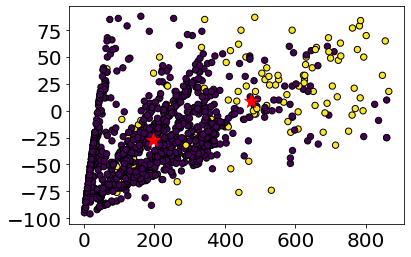

gpuls
nbumps


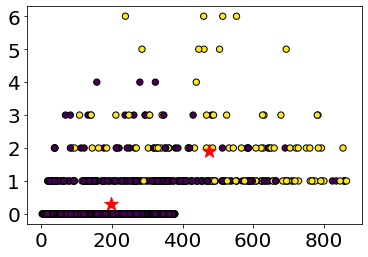

gpuls
nbumps2


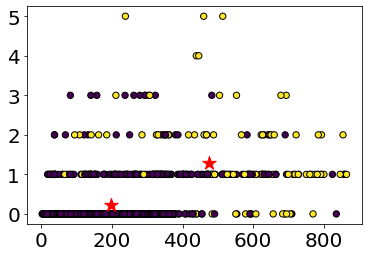

gpuls
nbumps3


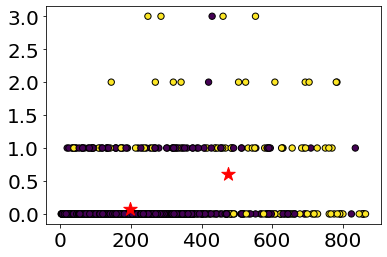

gpuls
energy


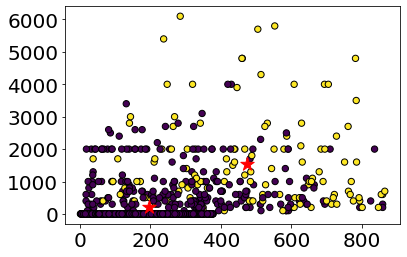

gdenergy
genergy


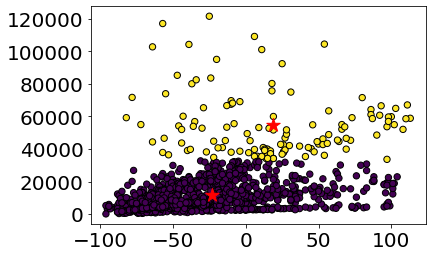

gdenergy
gpuls


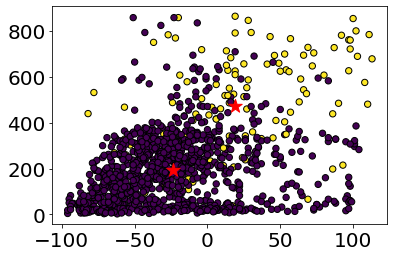

gdenergy
gdenergy


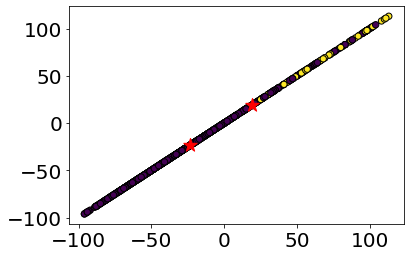

gdenergy
gdpuls


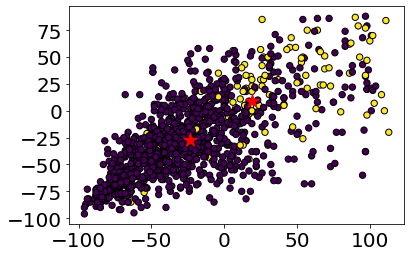

gdenergy
nbumps


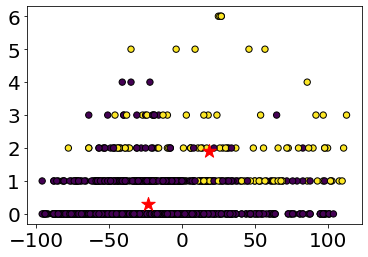

gdenergy
nbumps2


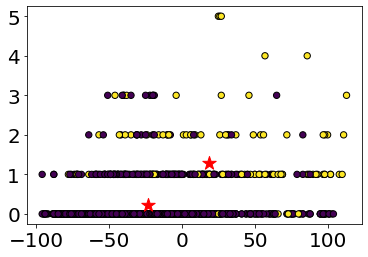

gdenergy
nbumps3


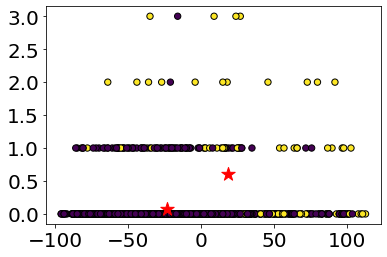

gdenergy
energy


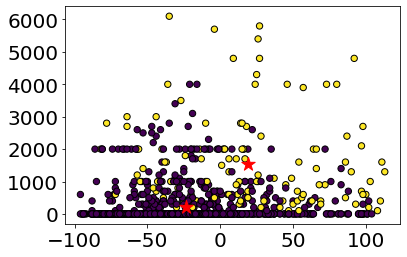

gdpuls
genergy


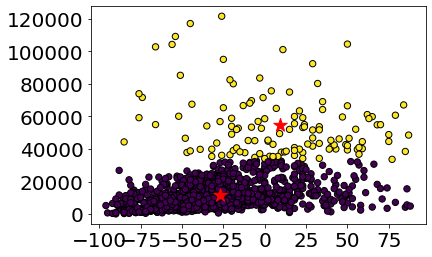

gdpuls
gpuls


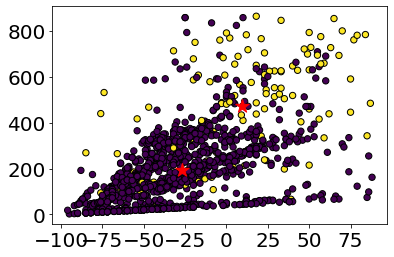

gdpuls
gdenergy


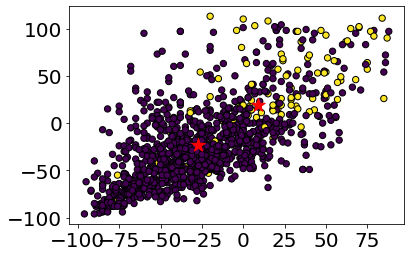

gdpuls
gdpuls


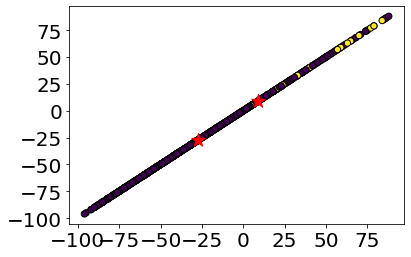

gdpuls
nbumps


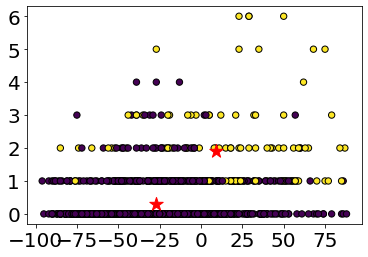

gdpuls
nbumps2


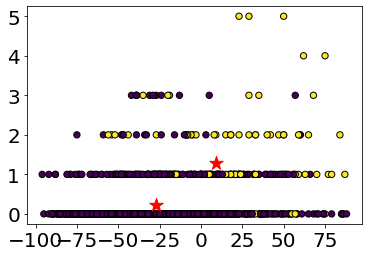

gdpuls
nbumps3


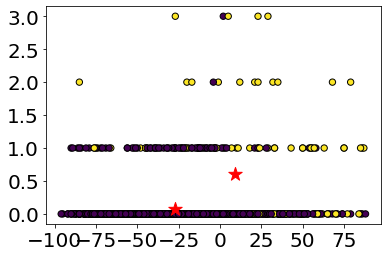

gdpuls
energy


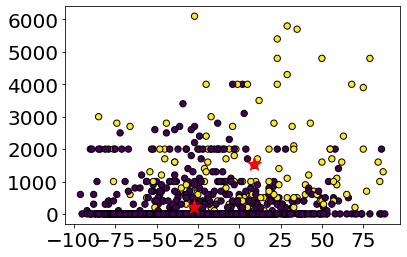

nbumps
genergy


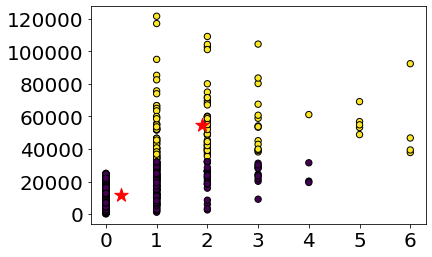

nbumps
gpuls


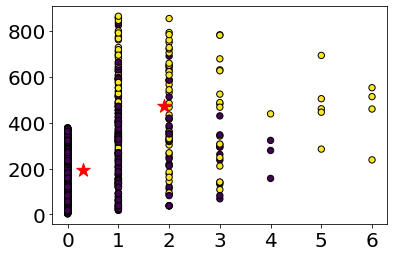

nbumps
gdenergy


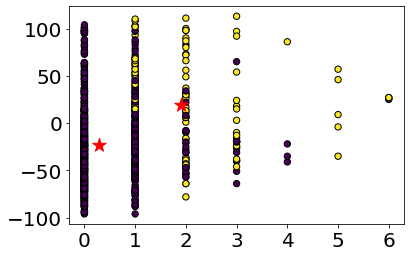

nbumps
gdpuls


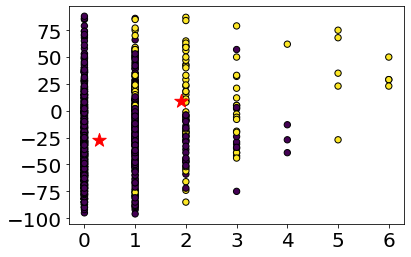

nbumps
nbumps


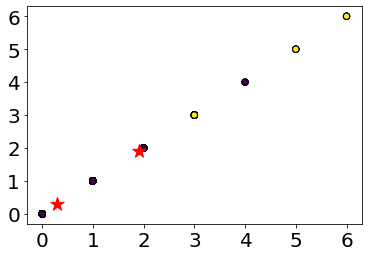

nbumps
nbumps2


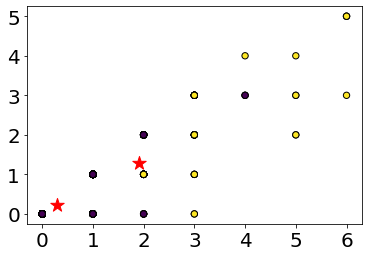

nbumps
nbumps3


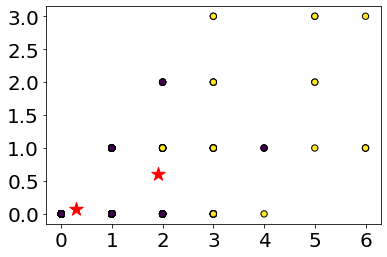

nbumps
energy


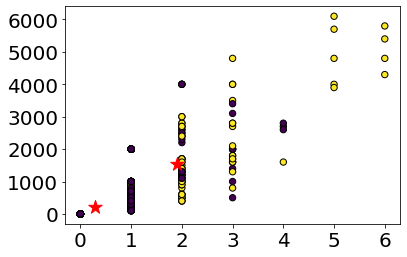

nbumps2
genergy


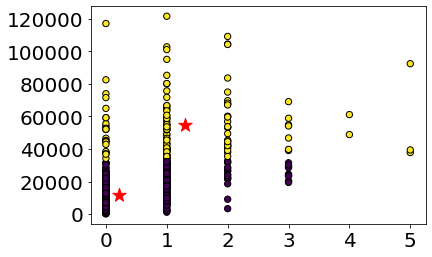

nbumps2
gpuls


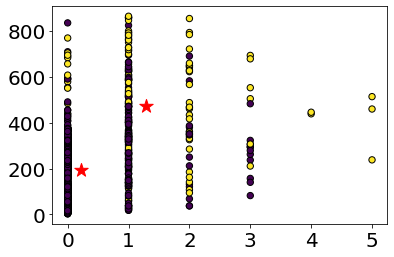

nbumps2
gdenergy


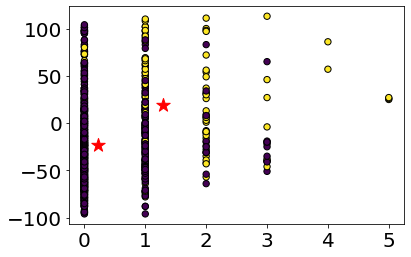

nbumps2
gdpuls


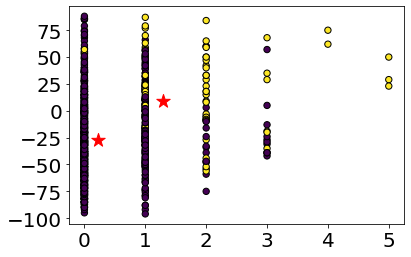

nbumps2
nbumps


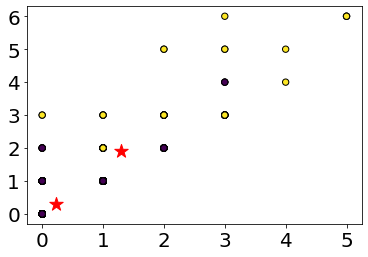

nbumps2
nbumps2


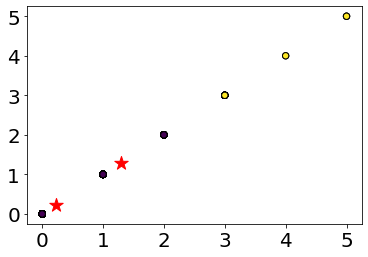

nbumps2
nbumps3


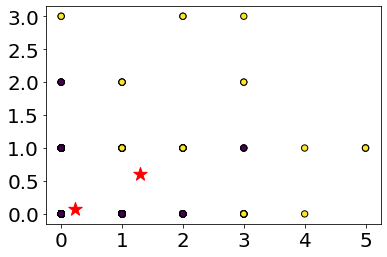

nbumps2
energy


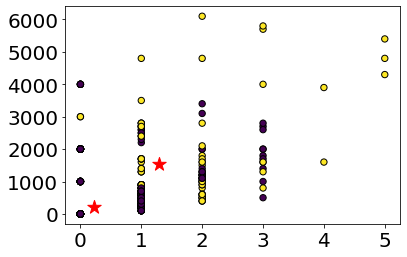

nbumps3
genergy


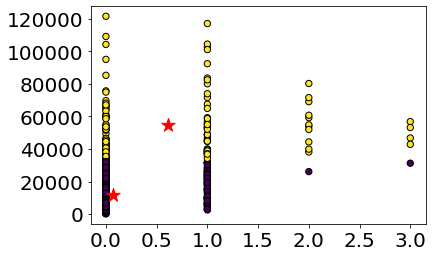

nbumps3
gpuls


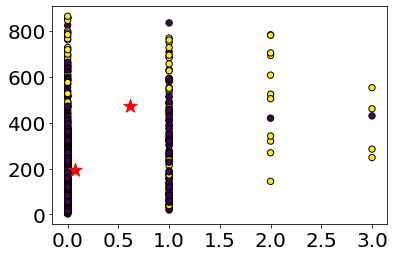

nbumps3
gdenergy


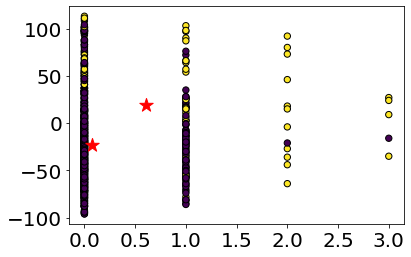

nbumps3
gdpuls


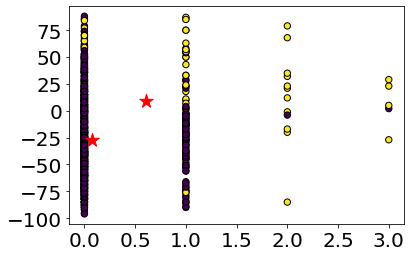

nbumps3
nbumps


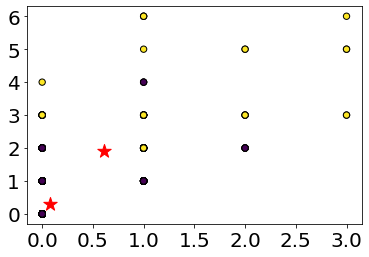

nbumps3
nbumps2


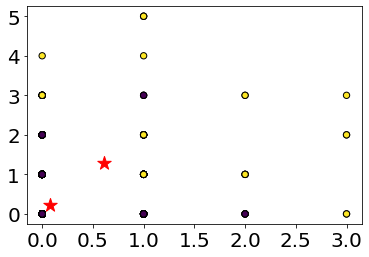

nbumps3
nbumps3


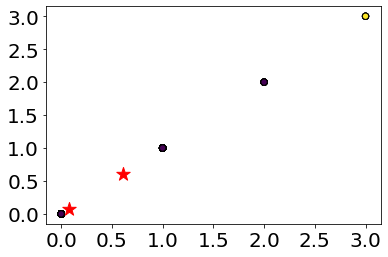

nbumps3
energy


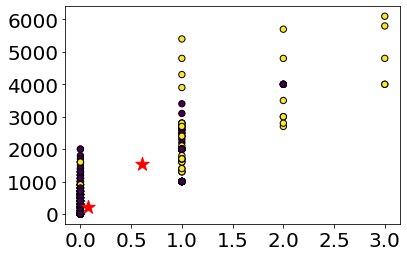

energy
genergy


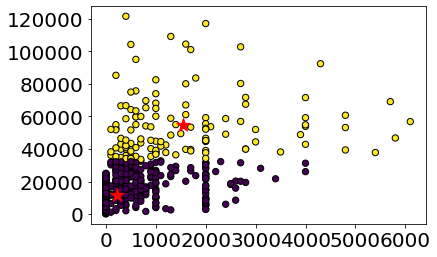

energy
gpuls


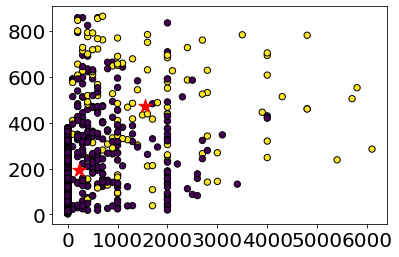

energy
gdenergy


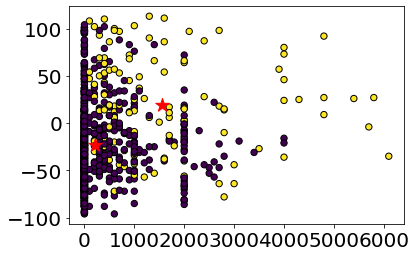

energy
gdpuls


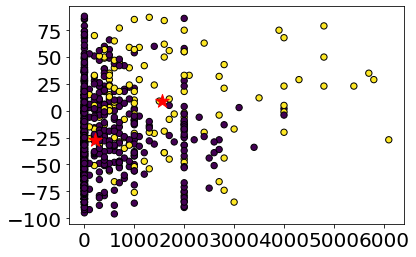

energy
nbumps


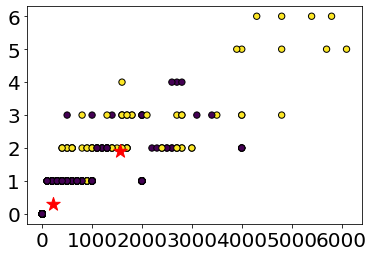

energy
nbumps2


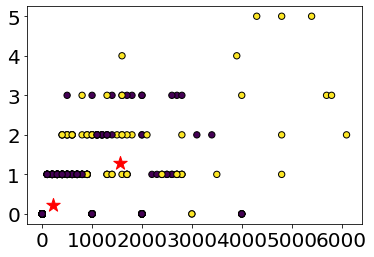

energy
nbumps3


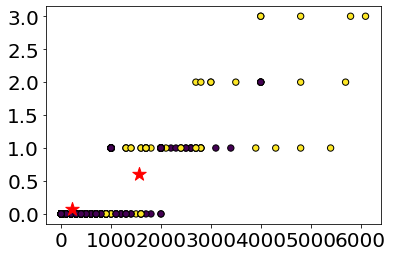

energy
energy


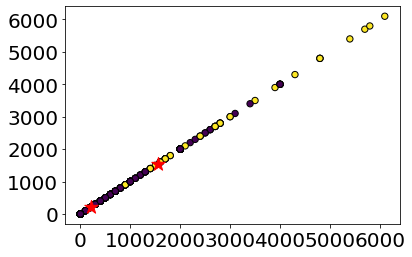

In [109]:
for i in range (0, len(cols)-1):
    for j in range (0, len(cols)-1):
        plt.scatter( X[:,i], X[:,j], s=40, edgecolor='black', c= kmeans.labels_ )
        plt.scatter( centers[:,i], centers[:,j], c='red', marker='*', s=200 )

        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        print(df_x[i])
        print(df_x[j])

        plt.show()

[]

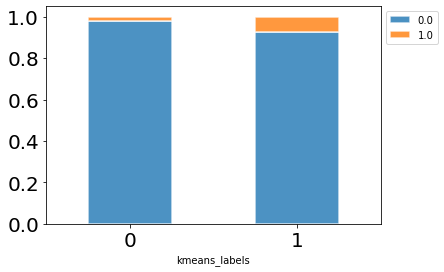

In [110]:
df['kmeans_labels'] = kmeans.labels_

clust_name = ['0', '1']
bar_pl = df['class'].groupby(df['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='white', linewidth=1.5)

plt.xticks(range(0, len(clust_name)), clust_name, fontsize=20, rotation=0)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1,1))

plt.plot()

In [111]:
print('SSE', kmeans.inertia_)
print('Silhouette', silhouette_score(X, kmeans.labels_))

SSE 103995316453.66232
Silhouette 0.7437805793263169


In [113]:
sse_list = []

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_minmax)
    sse_list.append( kmeans.inertia_ )

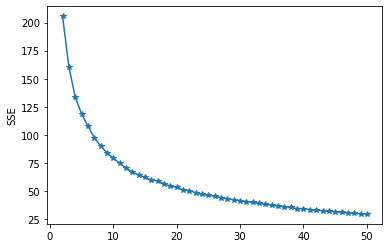

In [114]:
plt.plot(range(2, len(sse_list)+2), sse_list, marker='*')
plt.ylabel('SSE')
plt.show()

In [135]:
dbscan = DBSCAN( eps=0.3, min_samples=5)
dbscan.fit(X_minmax)

DBSCAN(eps=0.3)

In [136]:
dbscan.labels_

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

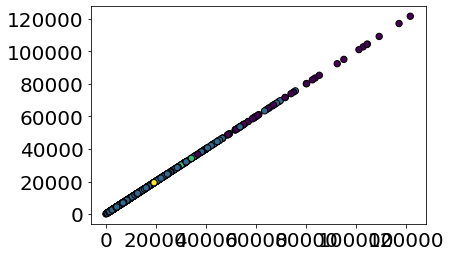

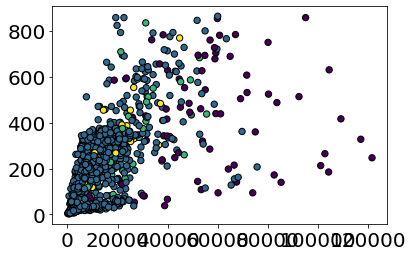

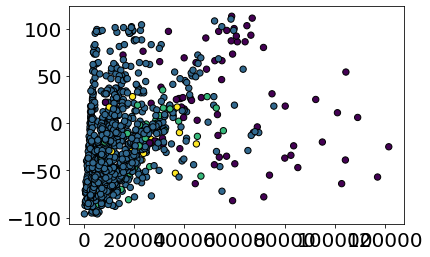

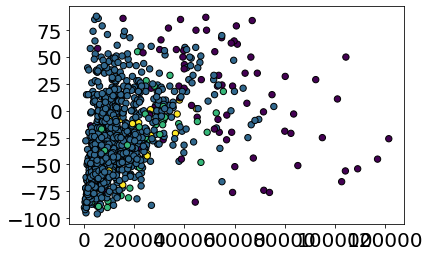

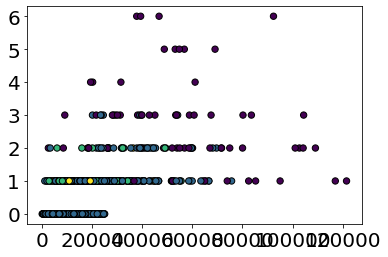

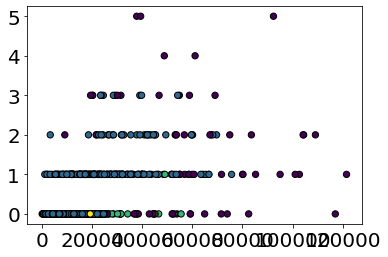

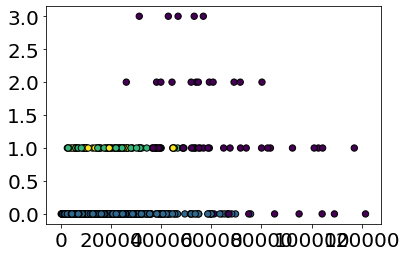

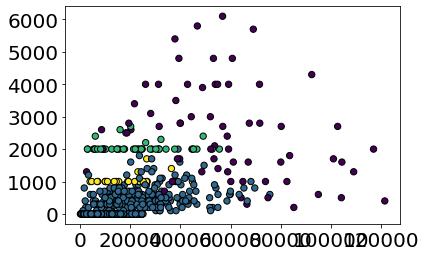

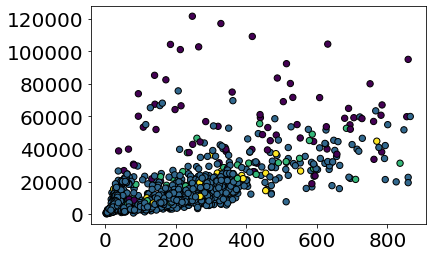

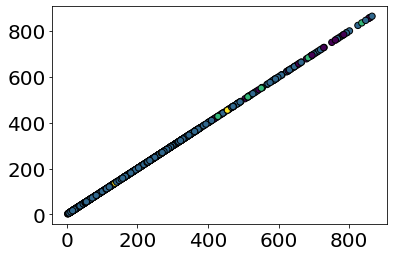

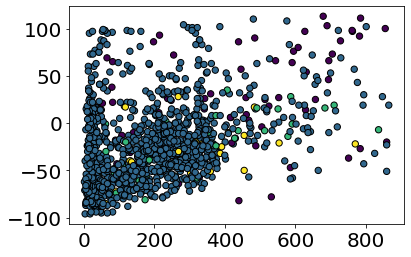

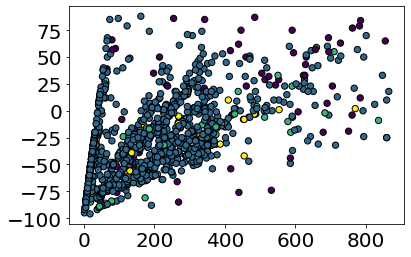

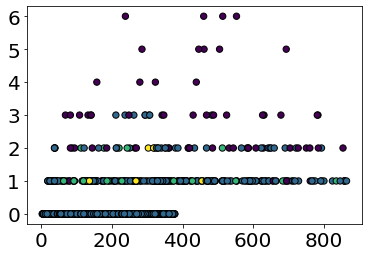

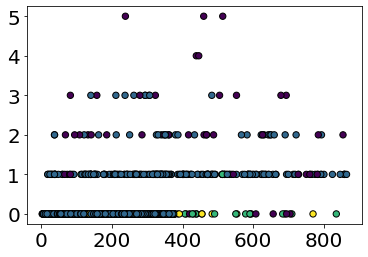

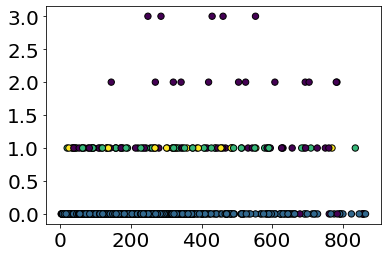

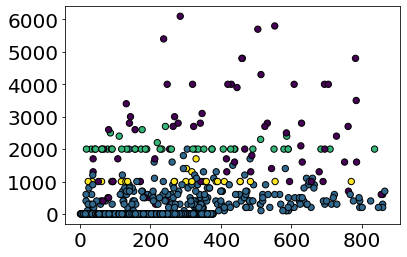

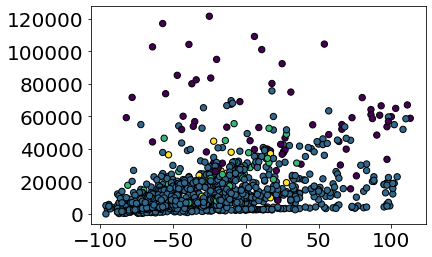

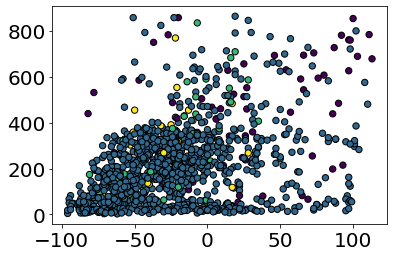

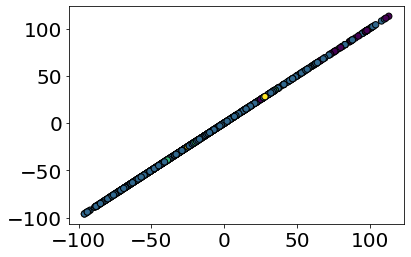

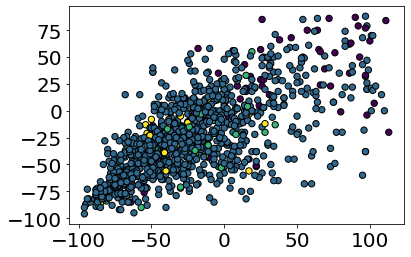

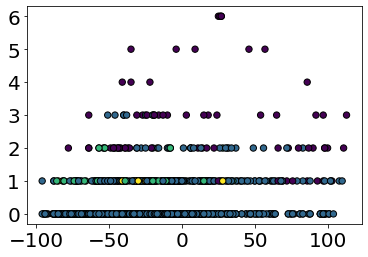

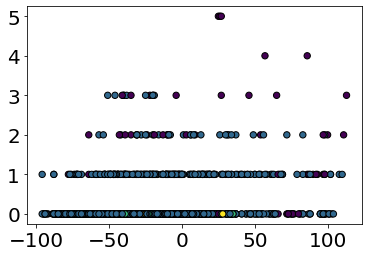

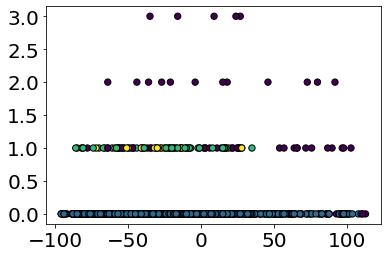

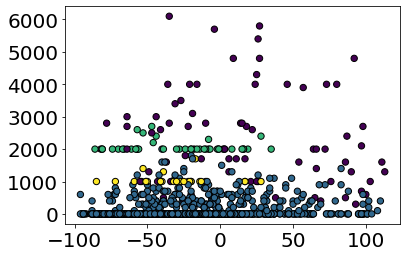

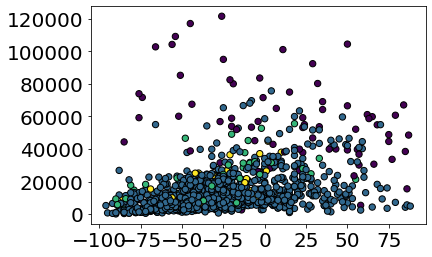

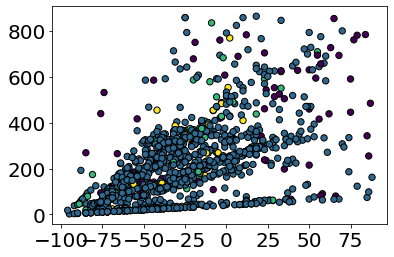

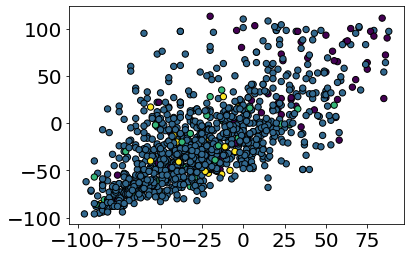

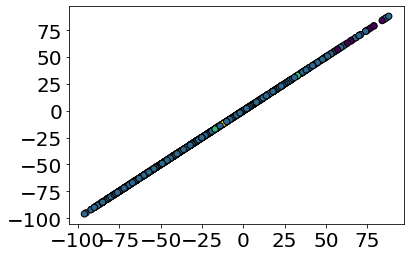

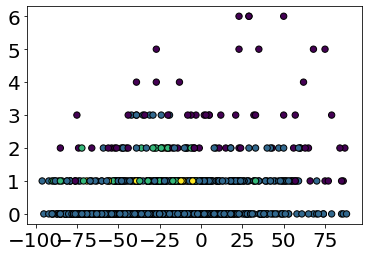

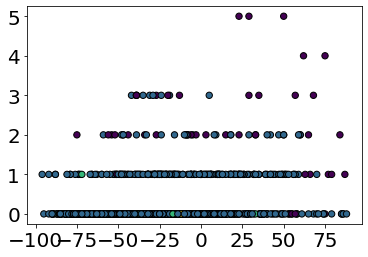

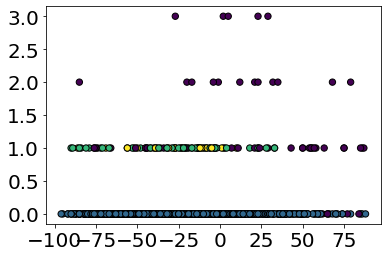

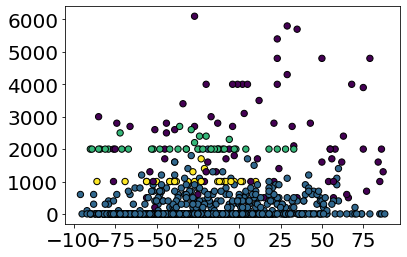

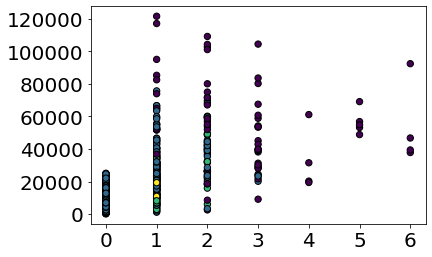

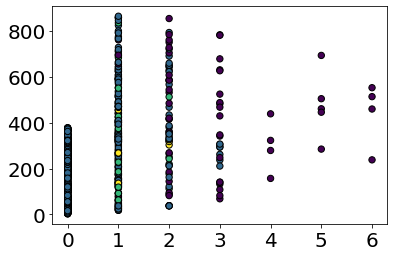

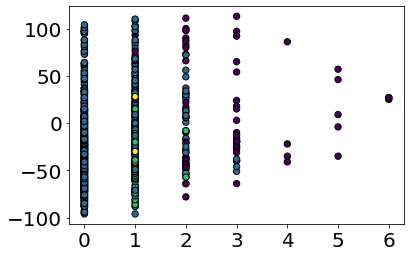

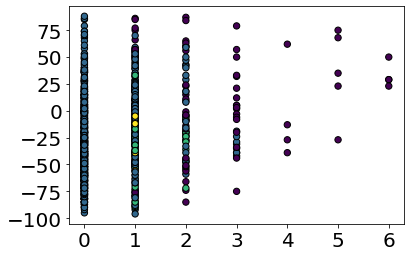

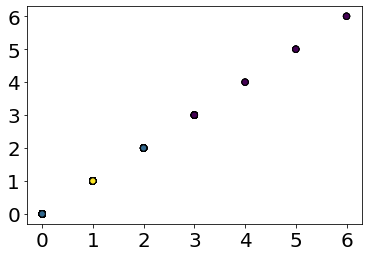

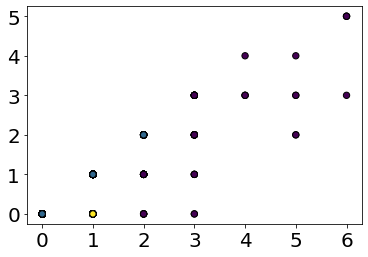

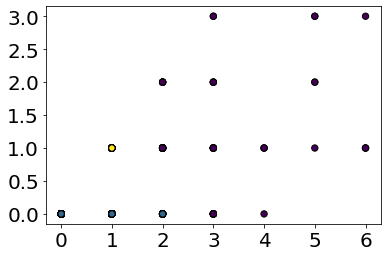

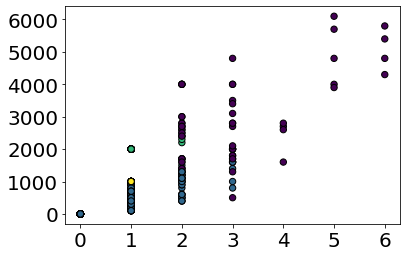

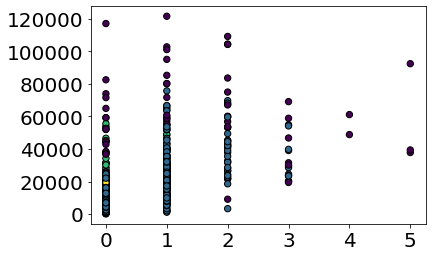

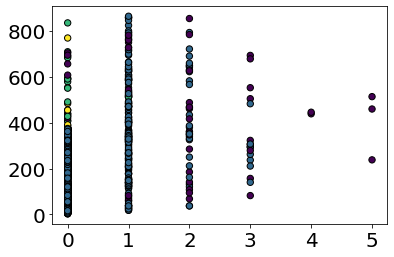

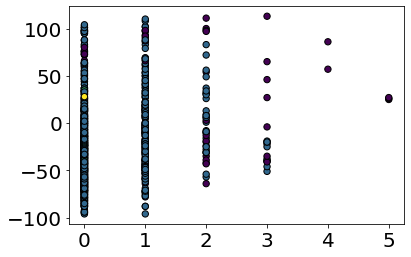

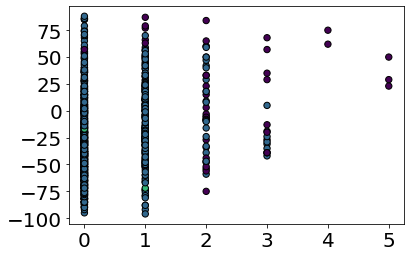

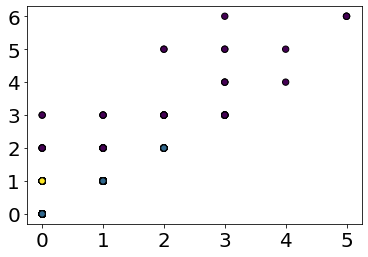

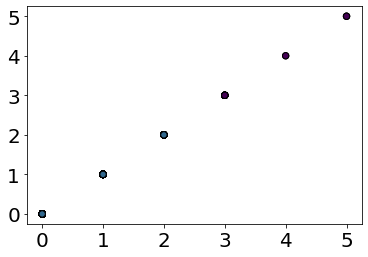

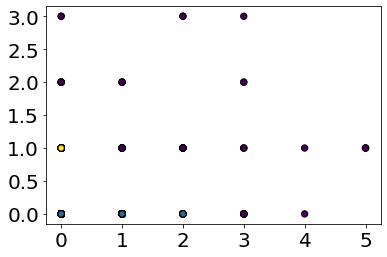

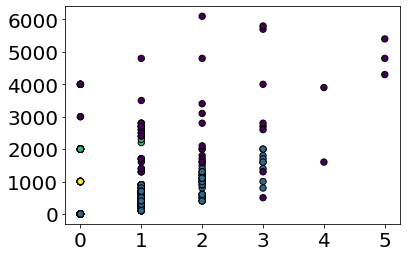

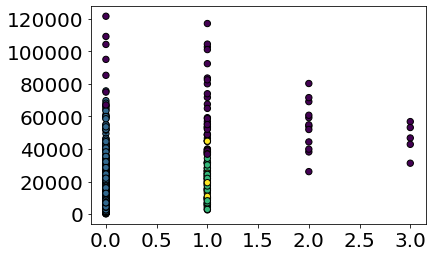

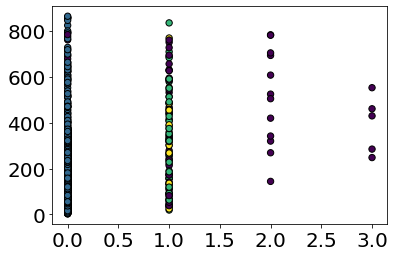

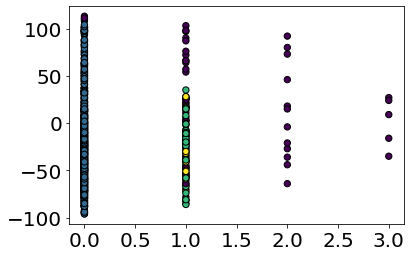

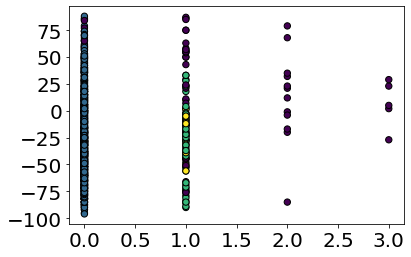

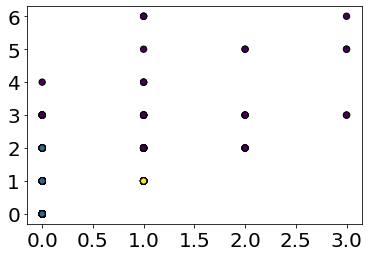

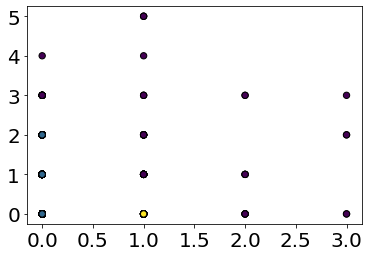

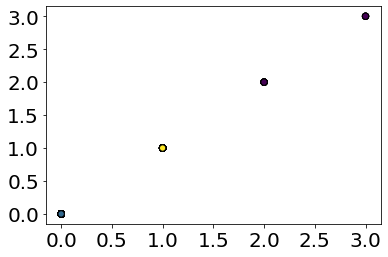

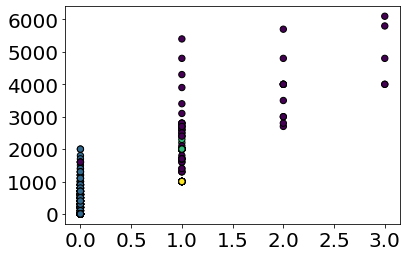

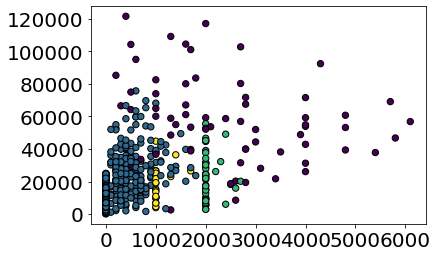

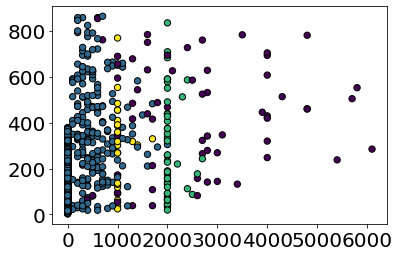

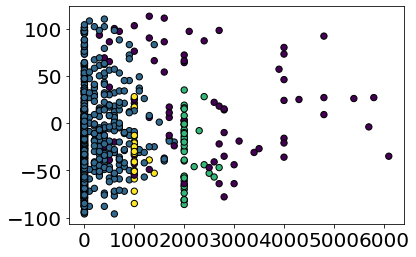

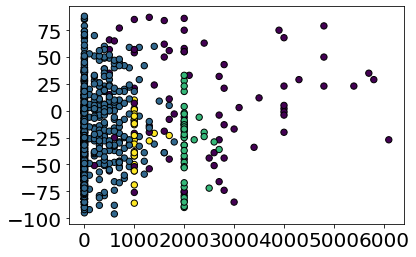

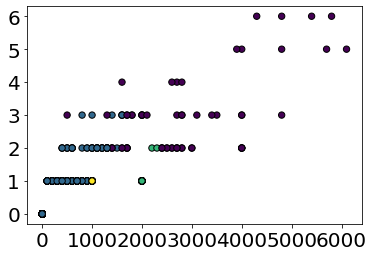

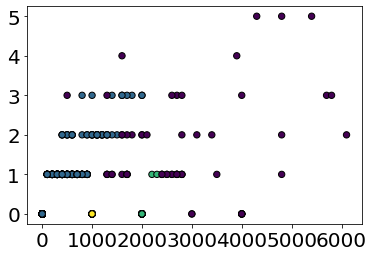

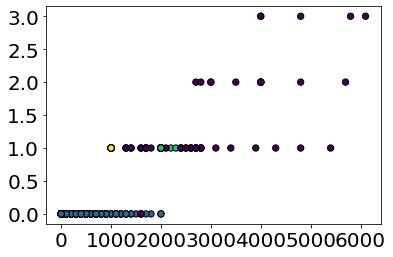

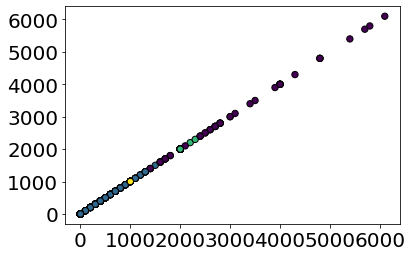

In [137]:
for i in range (0, len(cols)-1):
    for j in range (0, len(cols)-1):
        plt.scatter( X[:,i], X[:,j], s=40, edgecolor='black', c= dbscan.labels_ )

        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)

        plt.show()

In [121]:
dist = pdist(X_minmax, 'euclidean')
dist = squareform(dist)

k=5
kth_distances = []
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

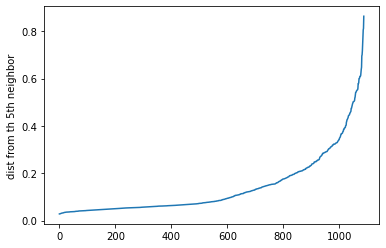

In [122]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from th 5th neighbor')
         
plt.show()

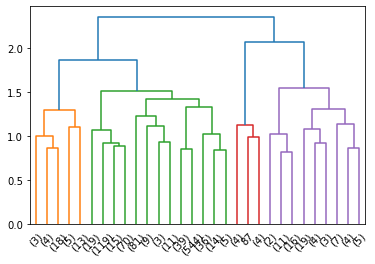

In [123]:
data_dist = pdist(X_minmax, metric='euclidean')
data_link = linkage(data_dist, method='complete')

res = dendrogram(data_link, truncate_mode='lastp')